___

<a href='https://github.com/eliasmelul/'> <img src='https://s3.us-east-2.amazonaws.com/wordontheamazon.com/BlueLogoNoBackground.png' style='width: 8em;' align='right' /></a>
# Capstone Project: Finding my Schitt's Creek
___
<h3 align="right">by Elias Melul, Data Scientist </h3> 

___



**Table of Contents**

1. <a id='BusinessUnderstanding'></a>[Business Understanding](#BusinessUnderstanding)
2. <a id='DataCollection'></a>[Data Collection](#DataCollection)
3. 

<h2 id = "BusinessUnderstanding">Business Understanding</h2>

The purpose of this capstone project is quite simple, and one that many people have encountered.
_______________________________________________________________________________________________________________________

Most of us have heard of New York City, Boston, San Francisco, Chicago, Miami... all very different cities with a lot to offer. However, there are many incredible cities in the United States, cities that we might not know much about, nor we learn about until someone introduces us to it!

As an international student in the US, I constantly wonder if my desire to go to one of the big cities (NYC, Boston, San Fran. etc.) is valid and if there are other places in the US that I may not know of. I go to Duke University, and I really liked Raleigh-Durham. Had I not gone there, I would not have known!

-------------------

So I am going to classify the cities based on an amalgalm of features to see which one are statistically most similar than others. I will also attempt to build a recommendator system that takes your favorite cities (and least favorites!) and the rating you give them and return other cities with similar characteristics. Feel free to try it out!

<h2 id = "DataCollection">Data Collection</h2>

In order to create a good clustering model and a competent recommender system, I need information from cities in the USA, and lots of it! 

----
**Which cities will I include?**

I found [this](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population) Wikipedia site that includes a table of the top 314 most populated cities in the USA. We will use these cities to scrape the web, leverage FourSquare API, and gather as much data as possible to feed to our classificator model and our recommender system.

----
**What data will be collected and how?**

There is a CRAZY amount of data available on the web about all cities, but these can be very dispar and from numerous websites. Lucky me, I found [this](https://datausa.io/) website that contains most the information I need (thank you Deloitte and Datawheel!), so I will selectively choose to scrape metrics that I believe might be important. I will then combine this information with FourSquare information about venues and others to complete the dataframe and begin modeling!

**Some of the variables scraped are:**

* Population and Population Change (Year to Year)
* Poverty Rate
* Median Age
* Median Household Income and Median Household Income Change (Year to Year)
* Number of Employees and Number of Employees Change (Year to Year)
* Median Property Value and Median Property Value Change (Year to Year)
* Average Male and Female Salary, and a ratio of Average Male to Female Salary
* Gini coefficient in 2017 and 2018, as well as it's change (Year to Year)
* Ratio of Patients to Clinicians (county-wise)
* Foreign-born population percentage
* Citizen population percentage
* Total degrees awarded in 2018 (higher education)
* Male to Female ratio of awarded degrees
* Number of degrees per capita
* Number of households in city
* Population per household (people per household)
* Homeownership Percentage (Rent vs Own)
* Average Commute Time (minutes)

#### Import Libraries

In [2]:
import pandas as pd # import pandas for dataframes
import numpy as np
import requests
from bs4 import BeautifulSoup
import locale
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
import json
import folium
from pandas.io.json import json_normalize


import matplotlib.cm as cm
import matplotlib.colors as colors

from IPython.display import HTML, display
from IPython.display import Image 
from IPython.core.display import HTML 

pd.options.display.max_columns = None
pd.options.display.max_rows=None


%matplotlib inline

<h3 id ="GettingList">Getting List of Cities</h3>

#### Load Wikipedia Data for City Names

In [3]:
all_cities = pd.read_html('https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population')[4]
all_cities.head()

,2018rank,City,State[c],2018estimate,2010Census,Change,2016 land area,2016 land area.1,2016 population density,2016 population density.1,Location
0,1,New York[d],New York,8398748,8175133,+2.74%,301.5 sq mi,780.9 km2,"28,317/sq mi","10,933/km2",40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W
1,2,Los Angeles,California,3990456,3792621,+5.22%,468.7 sq mi,"1,213.9 km2","8,484/sq mi","3,276/km2",34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°W
2,3,Chicago,Illinois,2705994,2695598,+0.39%,227.3 sq mi,588.7 km2,"11,900/sq mi","4,600/km2",41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W
3,4,Houston[3],Texas,2325502,2100263,+10.72%,637.5 sq mi,"1,651.1 km2","3,613/sq mi","1,395/km2",29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W
4,5,Phoenix,Arizona,1660272,1445632,+14.85%,517.6 sq mi,"1,340.6 km2","3,120/sq mi","1,200/km2",33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°W


There are three clear problems with the imported table above:
1. **Some of the city names have square brakets due to footnotes included in the table. We must get rid of them.**
2. **The state column is not abbreviated. Why is this an issue? Because of the url format datausa.io has. This will become clear in the next section.**
3. **The format of the values for each city is not adequate. We need to convert number to numeric.**

**Lets fix problem 1: deleting everything within square brakets in the City column.**

In [4]:
for i, row in all_cities.iterrows():
    ifor_val = re.sub(r'\[.*\]', '', row.City)
    all_cities.at[i,'City'] = ifor_val
all_cities.head()

,2018rank,City,State[c],2018estimate,2010Census,Change,2016 land area,2016 land area.1,2016 population density,2016 population density.1,Location
0,1,New York,New York,8398748,8175133,+2.74%,301.5 sq mi,780.9 km2,"28,317/sq mi","10,933/km2",40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W
1,2,Los Angeles,California,3990456,3792621,+5.22%,468.7 sq mi,"1,213.9 km2","8,484/sq mi","3,276/km2",34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°W
2,3,Chicago,Illinois,2705994,2695598,+0.39%,227.3 sq mi,588.7 km2,"11,900/sq mi","4,600/km2",41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W
3,4,Houston,Texas,2325502,2100263,+10.72%,637.5 sq mi,"1,651.1 km2","3,613/sq mi","1,395/km2",29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W
4,5,Phoenix,Arizona,1660272,1445632,+14.85%,517.6 sq mi,"1,340.6 km2","3,120/sq mi","1,200/km2",33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°W


Lets also rename the columns and subset the data to the useful columns.

In [5]:
all_cities.rename(columns={'2018rank':'Rank',
                  'State[c]':'State',
                  '2018estimate':'Population_2018',
                  '2010Census':'Population_2010',
                  '2016 land area.1':'Land_Area_km2',
                  '2016 population density.1':'Population_Density_per_km2'}, inplace=True)


all_cities = all_cities[['City','State','Land_Area_km2','Population_Density_per_km2', 'Location']]
all_cities.head()

,City,State,Land_Area_km2,Population_Density_per_km2,Location
0,New York,New York,780.9 km2,"10,933/km2",40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W
1,Los Angeles,California,"1,213.9 km2","3,276/km2",34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°W
2,Chicago,Illinois,588.7 km2,"4,600/km2",41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W
3,Houston,Texas,"1,651.1 km2","1,395/km2",29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W
4,Phoenix,Arizona,"1,340.6 km2","1,200/km2",33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°W


**Lets fix problem 2: Adding State abbreviations**

To add the abbreviations, we must get a list of abbreviations and their respective states spelled out. Luckily, Wikipedia has a site listing all the US abbreviations! We will first import them, and then add the appropiate abbreviation to each City in our dataframe.

In [6]:
abb_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations', skiprows=11)[0]
abb_df = abb_df[['United States of America', 'Unnamed: 5']]
abb_df = abb_df.rename(columns={'United States of America':'State','Unnamed: 5':'State_Abb'})
abb_df.head()

,State,State_Abb
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [7]:
all_cities = all_cities.merge(abb_df, on='State')
all_cities.tail()

,City,State,Land_Area_km2,Population_Density_per_km2,Location,State_Abb
311,Columbia,South Carolina,345.8 km2,388/km2,34°01′45″N 80°53′53″W﻿ / ﻿34.0291°N 80.8980°W,SC
312,North Charleston,South Carolina,190.9 km2,573/km2,32°55′04″N 80°03′54″W﻿ / ﻿32.9178°N 80.0650°W,SC
313,Fargo,North Dakota,127.7 km2,950/km2,46°51′55″N 96°49′44″W﻿ / ﻿46.8652°N 96.8290°W,ND
314,Manchester,New Hampshire,85.7 km2,"1,289/km2",42°59′06″N 71°26′39″W﻿ / ﻿42.9849°N 71.4441°W,NH
315,Billings,Montana,113.2 km2,975/km2,45°47′19″N 108°33′00″W﻿ / ﻿45.7885°N 108.5499°W,MT


**Lets fix problem 3: Formatting column contents**

In [8]:
for i, row in all_cities.iterrows():
    all_cities.at[i,'Land_Area_km2'] = float(row.Land_Area_km2[0:-4].replace(',',''))
    all_cities.at[i,'Population_Density_per_km2'] = float(row.Population_Density_per_km2[0:-4].replace(',',''))
all_cities.head()

,City,State,Land_Area_km2,Population_Density_per_km2,Location,State_Abb
0,New York,New York,780.9,10933,40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W,NY
1,Buffalo,New York,104.6,2455,42°53′33″N 78°51′35″W﻿ / ﻿42.8925°N 78.8597°W,NY
2,Rochester,New York,92.7,2253,43°10′12″N 77°37′01″W﻿ / ﻿43.1699°N 77.6169°W,NY
3,Yonkers,New York,46.6,4307,40°56′45″N 73°52′03″W﻿ / ﻿40.9459°N 73.8674°W,NY
4,Syracuse,New York,64.7,2214,43°02′28″N 76°08′37″W﻿ / ﻿43.0410°N 76.1436°W,NY


In [9]:
#Lets also create a column with standard city namage: New York, NY
all_cities = all_cities.rename(columns={'City':'City Name'})
all_cities['City'] = [row['City Name']+", "+row['State_Abb'] for i,row in all_cities.iterrows()]
all_cities.head()

,City Name,State,Land_Area_km2,Population_Density_per_km2,Location,State_Abb,City
0,New York,New York,780.9,10933,40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W,NY,"New York, NY"
1,Buffalo,New York,104.6,2455,42°53′33″N 78°51′35″W﻿ / ﻿42.8925°N 78.8597°W,NY,"Buffalo, NY"
2,Rochester,New York,92.7,2253,43°10′12″N 77°37′01″W﻿ / ﻿43.1699°N 77.6169°W,NY,"Rochester, NY"
3,Yonkers,New York,46.6,4307,40°56′45″N 73°52′03″W﻿ / ﻿40.9459°N 73.8674°W,NY,"Yonkers, NY"
4,Syracuse,New York,64.7,2214,43°02′28″N 76°08′37″W﻿ / ﻿43.0410°N 76.1436°W,NY,"Syracuse, NY"


In [10]:
#Lastly, we need to format the location. First, note that the location includes the latitude and longitude in two different formats.
for i, row in all_cities.iterrows():
    item = row.Location.split("/")[1].replace("°","").strip().split(" ")
    latitude = item[0][1:]
    longitude = item[1]
    if longitude[-1:] == "W":
        longitude = float(longitude[:-1])*-1
    else:
        longitude = float(longitude[:-1])
        
    if latitude[-1:] == "S":
        latitude = float(latitude[:-1])*-1
    else:
        latitude = float(latitude[:-1])
    
    all_cities.at[i,'Latitude'] = latitude
    all_cities.at[i,'Longitude'] = longitude

all_cities = all_cities.drop('Location', axis=1)

In [11]:
all_cities.head()

,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,City,Latitude,Longitude
0,New York,New York,780.9,10933,NY,"New York, NY",40.6635,-73.9387
1,Buffalo,New York,104.6,2455,NY,"Buffalo, NY",42.8925,-78.8597
2,Rochester,New York,92.7,2253,NY,"Rochester, NY",43.1699,-77.6169
3,Yonkers,New York,46.6,4307,NY,"Yonkers, NY",40.9459,-73.8674
4,Syracuse,New York,64.7,2214,NY,"Syracuse, NY",43.0410,-76.1436


Great! Now that these problems have been fixed, we can proceed to scraping the web for more data! 

---
For that, we will need a list of all the cities and their respective state abbreviation. Why? Because the path to our scrapping website is as follows:

    /city-name-state_abbretiation
    
    For example:
    /new-york-ny
 

However, not all URLs are that clear. Some contain paths that include 'metropolitan area' or some require a 'county'. For that reason, we will generate URLs that also include the following forms:

    /new-york-ny-metro-area
    /new-york-county-ny

Once we generate these URLs, we will check if they are valid, extract another list of only valid URLs and use those to scrape data.

#### Generating the URLs

In [12]:
cities_list = all_cities['City Name'] + " "+all_cities.State_Abb
cities_list = list(cities_list)
cities_list= [i.lower().replace(' ','-') for i in cities_list]

In [13]:
# Add -metro-area
cities_metro = [i+'-metro-area' for i in cities_list]

In [14]:
# #Add county possible urls
# county_list = all_cities['City Name'] +"-county-"+all_cities.State_Abb
# county_list = [i.lower().replace(' ','-') for i in county_list]

In [15]:
# Combine the lists
cities_list=cities_list+cities_metro#+county_list

In [16]:
#Concatenate the domain to the generated path to recreate all the URLS
urls_cities = ["https://datausa.io/profile/geo/"+i for i in cities_list]

In [17]:
len(urls_cities)

632

We have generated 632 possible URLs to scrap the data.

Let's check how many of them are valid and keep those for scraping.

In [18]:
#Check if url connections exist
checker = []
for url in urls_cities:
    c = requests.get(url)
    soup = BeautifulSoup(c.content, features='lxml')
    res = soup.find_all("h4",{"class":"pt-non-ideal-state-title"})
    if (len(res) > 0):
        exist = 0
    else:
        try:
            tes = soup.find("div",{"class":"content-container"})
            tes = tes.get_text()
            if (tes == 'N/A'):
                exist = 0
            else:
                exist =1
        except: 
            exist=1
            pass
           
    tempdic = {"URL":url,
              "Exist":exist}
    checker.append(tempdic)

checker = pd.DataFrame(checker)
checker.head()

,URL,Exist
0,https://datausa.io/profile/geo/new-york-ny,1
1,https://datausa.io/profile/geo/buffalo-ny,1
2,https://datausa.io/profile/geo/rochester-ny,1
3,https://datausa.io/profile/geo/yonkers-ny,1
4,https://datausa.io/profile/geo/syracuse-ny,1


In [22]:
existing = checker[checker.Exist==1]
print(f"The number of valid URLs is: {existing.shape[0]}")
nonexisting = checker[checker.Exist==0]
print(f"The number of invalid URLs is: {nonexisting.shape[0]}")

The number of valid URLs is: 373
The number of invalid URLs is: 259


In [23]:
#Create a list with the existing
urls_cities = existing['URL'].to_list()

As we can see, there are 373 URLs from our generated URL list. 

If we recall, there were only 314 cities on our list... it seems likely that have a lot repeat cities/areas due to the 'County' and 'Metro-Area' paths added. We will deal with this issue after scraping.

---
For now, let's have some fun!

#### Scraping dataUSA

For this section, we have defined everyhing as functions, so that we can easily iterate over all the URLs. 

---
The first function simply retrieves the text data from the HTML section specified by the class types and names.

---

The second function uses the first function to retrieve each metric wanted for each city as strings, and transforms such to the type desired. In this case, all the information is numeric except the name of the city. A dictionary will be returned.


In [24]:
def get_text_from_class(soup,classname,type1="div",type2="class"):
    city_content = soup.find(type1, {type2:classname})
    city_info = city_content.find_all('p')
    content_raw = []
    for i in city_info:
        i = str(i)
        removefirst = i[3:-4]
        content_raw.append(removefirst)
    return(content_raw)

In [25]:
def get_basic_city_info(url):
    html = requests.get(url=url)
    soup = BeautifulSoup(html.content, features='lxml')
    
    ###### Get content from dashboard
    #Name of the city
    city_name = soup.find("p").get_text()
    
    #Raw dashboard content
    content_raw = get_text_from_class(soup, "profile-stats")
    
    #Population of City
    Population = content_raw[1]
    
    if Population[-1:] == "M":
        Population = float(Population[0:-1])*1000000
    else:
        Population = float(Population.replace(',',''))
    
    #Population Change YTY
    Population_Change = content_raw[2]
    if Population_Change[-7:] == 'decline':
        Population_Change = float(Population_Change[0:-9])*-1
    else:
        Population_Change = float(Population_Change[0:-8])
        
    #Poverty Rate
    Poverty_Rate = float(content_raw[4][0:-1])
    
    #Median Age
    Median_Age = float(content_raw[7])
    
    #Median Household Income and Change
    Median_Household_Income = float(content_raw[10][1:].replace(',',''))
    Median_Household_Income_Change = content_raw[11]
    if Median_Household_Income_Change[-7:]=='decline':
        Median_Household_Income_Change = float(Median_Household_Income_Change[0:-9])*-1
    else:
        Median_Household_Income_Change = float(Median_Household_Income_Change[0:-8])
    
    #Number of Employees
    Number_Employees = content_raw[13]
    if Number_Employees[-1:] == "M":
        Number_Employees = float(Number_Employees[0:-1])*1000000
    else:
        Number_Employees = float(Number_Employees.replace(',',''))
    
    #Change Number of Employees
    Number_Employees_Change = content_raw[14]
    if Number_Employees_Change[-7:]=='decline':
        Number_Employees_Change = float(Number_Employees_Change[0:-9])*-1
    else:
        Number_Employees_Change = float(Number_Employees_Change[0:-8])
    
    #Median Property Value
    Median_Property_Value = content_raw[16][1:]
    if Median_Property_Value[-1:] == "M":
        Median_Property_Value = float(Median_Property_Value[0:-1])*1000000
    else:
        Median_Property_Value = float(Median_Property_Value.replace(',',''))
    
    #Median Property Value Change
    Median_Property_Value_Change = content_raw[17]
    if Median_Property_Value_Change[-7:]=='decline':
        Median_Property_Value_Change = float(Median_Property_Value_Change[0:-9])*-1
    else:
        Median_Property_Value_Change = float(Median_Property_Value_Change[0:-8])
    
    #Wage Distribution across genders
    wage_gender = get_text_from_class(soup, "topic income_gender TextViz")
    avg_male_salary = float(wage_gender[2][1:].replace(',',''))
    avg_female_salary = float(wage_gender[5][1:].replace(',',''))
    gender_salary_ratio = avg_male_salary/avg_female_salary
  
    #Gini coefficient distribution
    gini_coeff = get_text_from_class(soup, "topic income_distro TextViz")
    gini_2018 = float(gini_coeff[2])
    gini_2017 = float(gini_coeff[4])
    gini_change_percent = (gini_2018-gini_2017)*100/gini_2017
    
    #Health Ratio (Patients to Clinicians)
    health_ratio = get_text_from_class(soup, "topic clinician_patient_ratio TextViz")
    health_ratio = float(health_ratio[2].replace(' to 1','').replace(',',''))
    
    #Foreign Born Population
    foreign_ratio = get_text_from_class(soup, "topic foreign_born TextViz")
    foreign_ratio = float(foreign_ratio[1][:-1].replace(',',''))
    
    #Citizen Ratio
    citizen_ratio = get_text_from_class(soup, "topic citizenship TextViz")
    citizen_ratio = float(citizen_ratio[1][:-1].replace(',',''))
    
    #Degrees awareded
    # There seem to be some cities without education infomration... we need to handle this exception
    try:
        degrees_awarded = get_text_from_class(soup, "topic edu_gender TextViz")
        degrees_men = float(degrees_awarded[1].replace(',',''))
        degrees_women = float(degrees_awarded[3].replace(',',''))
        degrees_gender_ratio_M2F = degrees_men/degrees_women 
        total_degrees = degrees_men+degrees_women
        degrees_per_capita = total_degrees/Population
    except:
        total_degrees = 0
        degrees_gender_ratio_M2F = 1
        degrees_per_capita = None
    
    #Number of Households
    households = get_text_from_class(soup, "topic household_income TextViz")
    households = households[5]
    if households[-1:] == "M":
        households = float(households[0:-1])*1000000
    elif households[-1:]=="k":
        households = float(households[0:-1])*1000
    else:
        households = float(households.replace(',',''))
    people_per_house = Population/households
    
    #Rent vs Ownership of Homes
    rent_own = get_text_from_class(soup, "topic rent_own TextViz")
    rent_own = float(rent_own[1][:-1])
    
    #Communite time
    commute_time = get_text_from_class(soup, "topic commute_time TextViz")
    commute_time = float(commute_time[1][:-8])
    
    basic_information = {'City':city_name,
                        'Population':Population,
                        'Population Change':Population_Change,
                        'Poverty Rate':Poverty_Rate,
                        'Median Age':Median_Age,
                        'Median Household Income':Median_Household_Income,
                        'Median Household Income Change':Median_Household_Income_Change,
                        'Number Employees':Number_Employees,
                        'Number Employees Change':Number_Employees_Change,
                        'Median Property Value':Median_Property_Value,
                        'Median Property Value Change':Median_Property_Value_Change,
                        'Average Male Salary':avg_male_salary,
                        'Average Female Salary':avg_female_salary,
                        'Gender Salary Ratio M2F':gender_salary_ratio,
                        'Gini 2018':gini_2018,
                        'Gini Change':gini_change_percent,
                        'Patient to Clinician Ratio':health_ratio,
                        'Foreign Born Population Ratio':foreign_ratio,
                        'Citizens Percentage':citizen_ratio,
                        'Total Degrees':total_degrees,
                        'Degrees Ratio M2F':degrees_gender_ratio_M2F,
                        'Degrees per Capita':degrees_per_capita,
                        'Households':households,
                        'People Per House':people_per_house,
                        'Homeownership':rent_own,
                        'Commute Time':commute_time}
    
    
    return basic_information

##### Functions Use Example

We will use NYC to see how the functions work and how the output looks.

In [26]:
url = 'https://datausa.io/profile/geo/new-york-ny'

In [27]:
get_basic_city_info(url)

{'City': 'New York, NY',
 'Population': 8400000.0,
 'Population Change': -2.6,
 'Poverty Rate': 19.6,
 'Median Age': 36.9,
 'Median Household Income': 63799.0,
 'Median Household Income Change': 4.8,
 'Number Employees': 4090000.0,
 'Number Employees Change': -2.21,
 'Median Property Value': 645100.0,
 'Median Property Value Change': 5.84,
 'Average Male Salary': 81735.0,
 'Average Female Salary': 63914.0,
 'Gender Salary Ratio M2F': 1.2788277998560567,
 'Gini 2018': 0.493,
 'Gini Change': -0.8048289738430591,
 'Patient to Clinician Ratio': 1553.0,
 'Foreign Born Population Ratio': 36.9,
 'Citizens Percentage': 84.3,
 'Total Degrees': 147053.0,
 'Degrees Ratio M2F': 0.608367056764738,
 'Degrees per Capita': 0.017506309523809525,
 'Households': 3180000.0,
 'People Per House': 2.641509433962264,
 'Homeownership': 32.8,
 'Commute Time': 40.1}

**Now that we have defined these functions, lets iterate over all our valid URLs to extract the specified metrics**

While running through the iterations of each city URL, there were some probleatic valid URLs. Take [Louisville, KY](https://datausa.io/profile/geo/louisville-ky) as an example. It does not contain the dashboard we typically use to extract some of the basic information. In addition, if has a bunch of NAs in the values we scrape from other parts of the website. Hence we are going to take these problematic URLs off the list.

---
**Dropping specific URLs**

In [28]:
urls_cities.remove('https://datausa.io/profile/geo/louisville-ky')

**Iterate over all valid URLs and extract all the information specified in our function**

In [29]:
cities_basic = []
for url in urls_cities:
    data = get_basic_city_info(url)
    cities_basic.append(data)

In [30]:
len(cities_basic)

372

In [31]:
cities = pd.DataFrame(cities_basic)
print(cities.shape)
cities.head()

(372, 26)


,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time
0,"New York, NY",8400000.0,-2.6000,19.6,36.9,63799.0,4.80,4090000.0,-2.210,645100.0,5.840,81735.0,63914.0,1.278828,0.493,-0.804829,1553.0,36.90,84.3,147053.0,0.608367,0.017506,3180000.0,2.641509,32.8,40.1
1,"Buffalo, NY",256322.0,-0.8780,30.9,33.3,37359.0,7.31,114478.0,-4.780,98300.0,6.040,81735.0,63914.0,1.278828,0.493,-0.804829,1243.0,9.49,93.9,8053.0,0.684376,0.031418,109000.0,2.351578,41.6,18.9
2,"Rochester, NY",209463.0,-0.3940,33.1,31.7,32347.0,2.09,90549.0,1.620,79400.0,2.060,76804.0,59246.0,1.296358,0.499,0.402414,966.0,8.71,94.9,3985.0,0.933527,0.019025,86200.0,2.429965,36.5,19.5
3,"Yonkers, NY",200999.0,0.6380,16.4,38.8,62399.0,1.84,94272.0,2.710,380100.0,0.158,76804.0,59246.0,1.296358,0.499,0.402414,728.0,30.60,87.0,561.0,0.342105,0.002791,74400.0,2.701599,47.3,33.3
4,"Syracuse, NY",144405.0,0.0381,32.6,30.6,34716.0,6.15,58724.0,0.118,91100.0,1.330,76804.0,59246.0,1.296358,0.499,0.402414,1050.0,12.50,92.1,8707.0,0.784953,0.060296,55600.0,2.597212,38.3,17.8


Amazing! We have scraped information about 372 cities and/or metropolitan areas - all containing 26 metrics that may be useful in our segmentation and recommendation problem.

Before we join the two tables, there is a critical issue to resolve: we have more rows in the scraped dataframe than we have cities on our list!

In [32]:
dupli = cities[cities.duplicated()] #Gets duplicated rows - where the WHOLE row is duplicated
dupli

,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time


In [33]:
dupli = cities[cities['City'].duplicated(keep=False)]
dupli.shape
dupli.head()

,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time
2,"Rochester, NY",209463.0,-0.3940,33.1,31.7,32347.0,2.09,90549.0,1.620,79400.0,2.06,76804.0,59246.0,1.296358,0.499,0.402414,966.0,8.71,94.9,3985.0,0.933527,0.019025,86200.0,2.429965,36.5,19.5
4,"Syracuse, NY",144405.0,0.0381,32.6,30.6,34716.0,6.15,58724.0,0.118,91100.0,1.33,76804.0,59246.0,1.296358,0.499,0.402414,1050.0,12.50,92.1,8707.0,0.784953,0.060296,55600.0,2.597212,38.3,17.8
9,"Fresno, CA",530073.0,0.5030,28.4,31.5,49813.0,2.50,219244.0,0.037,257200.0,9.68,78575.0,62298.0,1.261276,0.499,0.402414,1533.0,19.90,90.3,9907.0,0.558440,0.018690,171000.0,3.099842,44.2,21.8
22,"Modesto, CA",210166.0,0.7930,17.0,35.3,54024.0,5.94,86370.0,3.270,236200.0,13.60,72235.0,57252.0,1.261703,0.500,0.000000,1525.0,18.10,90.8,2805.0,0.482558,0.013347,71400.0,2.943501,54.6,26.0
39,"Salinas, CA",156811.0,0.5910,17.2,30.2,54864.0,4.83,67547.0,0.551,342100.0,12.60,72235.0,57252.0,1.261703,0.500,0.000000,1702.0,37.80,70.8,1919.0,0.521808,0.012238,40600.0,3.862340,44.5,22.6


In [34]:
dupli = dupli.sort_values(by='Population', ascending=False)
dupli = dupli.reset_index().drop('index', axis=1)
dupli.head()

,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time
0,"Pittsburgh, PA",2320000.0,-0.370,11.8,43.1,59710.0,2.030,1170000.0,0.509,160300.0,4.57,69779.0,52119.0,1.338840,0.469,-0.635593,1232.0,3.78,98.2,39982.0,0.763030,0.017234,1010000.0,2.297030,69.6,25.4
1,"Columbus, OH",2110000.0,1.340,14.0,36.1,64052.0,0.452,1070000.0,1.040,196700.0,7.90,65155.0,48520.0,1.342848,0.460,0.656455,1307.0,7.26,95.5,33833.0,0.778905,0.016035,802000.0,2.630923,61.9,22.5
2,"Jacksonville, FL",1530000.0,1.970,13.9,38.8,60238.0,2.600,727956.0,2.880,217200.0,5.90,62257.0,46612.0,1.335643,0.474,0.211416,1376.0,8.44,95.8,18224.0,0.709087,0.011911,575000.0,2.660870,63.5,25.2
3,"Oklahoma City, OK",1400000.0,0.918,14.6,35.3,57485.0,2.180,683637.0,2.550,160900.0,2.61,59946.0,41789.0,1.434492,0.465,3.563474,1587.0,7.85,94.9,22794.0,0.757305,0.016281,522000.0,2.681992,63.1,21.9
4,"Richmond, VA",1300000.0,0.160,12.4,38.8,67703.0,0.103,658555.0,1.150,246100.0,3.45,77546.0,58156.0,1.333414,0.480,0.628931,1316.0,7.23,95.6,16092.0,0.637363,0.012378,497000.0,2.615694,65.6,23.7


By sorting the data by population descending and reseting the index, we can now remove all duplicate rows based on their position. In other words, we can keep the first duplicate record - the metropolitan area one most likely.

In [35]:
dupli = dupli.drop_duplicates(subset='City',keep='first')
print(dupli.shape)
dupli.head()

(68, 26)


,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time
0,"Pittsburgh, PA",2320000.0,-0.370,11.8,43.1,59710.0,2.030,1170000.0,0.509,160300.0,4.57,69779.0,52119.0,1.338840,0.469,-0.635593,1232.0,3.78,98.2,39982.0,0.763030,0.017234,1010000.0,2.297030,69.6,25.4
1,"Columbus, OH",2110000.0,1.340,14.0,36.1,64052.0,0.452,1070000.0,1.040,196700.0,7.90,65155.0,48520.0,1.342848,0.460,0.656455,1307.0,7.26,95.5,33833.0,0.778905,0.016035,802000.0,2.630923,61.9,22.5
2,"Jacksonville, FL",1530000.0,1.970,13.9,38.8,60238.0,2.600,727956.0,2.880,217200.0,5.90,62257.0,46612.0,1.335643,0.474,0.211416,1376.0,8.44,95.8,18224.0,0.709087,0.011911,575000.0,2.660870,63.5,25.2
3,"Oklahoma City, OK",1400000.0,0.918,14.6,35.3,57485.0,2.180,683637.0,2.550,160900.0,2.61,59946.0,41789.0,1.434492,0.465,3.563474,1587.0,7.85,94.9,22794.0,0.757305,0.016281,522000.0,2.681992,63.1,21.9
4,"Richmond, VA",1300000.0,0.160,12.4,38.8,67703.0,0.103,658555.0,1.150,246100.0,3.45,77546.0,58156.0,1.333414,0.480,0.628931,1316.0,7.23,95.6,16092.0,0.637363,0.012378,497000.0,2.615694,65.6,23.7


In [36]:
cities = cities.drop_duplicates(subset='City', keep=False)
print(cities.shape)
cities.head()

(236, 26)


,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time
0,"New York, NY",8400000.0,-2.600,19.6,36.9,63799.0,4.80,4090000.0,-2.210,645100.0,5.840,81735.0,63914.0,1.278828,0.493,-0.804829,1553.0,36.90,84.3,147053.0,0.608367,0.017506,3180000.0,2.641509,32.8,40.1
1,"Buffalo, NY",256322.0,-0.878,30.9,33.3,37359.0,7.31,114478.0,-4.780,98300.0,6.040,81735.0,63914.0,1.278828,0.493,-0.804829,1243.0,9.49,93.9,8053.0,0.684376,0.031418,109000.0,2.351578,41.6,18.9
3,"Yonkers, NY",200999.0,0.638,16.4,38.8,62399.0,1.84,94272.0,2.710,380100.0,0.158,76804.0,59246.0,1.296358,0.499,0.402414,728.0,30.60,87.0,561.0,0.342105,0.002791,74400.0,2.701599,47.3,33.3
5,"Los Angeles, CA",3990000.0,-0.232,20.4,35.8,62474.0,3.78,2060000.0,0.509,682400.0,5.470,78575.0,62298.0,1.261276,0.499,0.402414,1391.0,37.10,80.7,78532.0,0.691261,0.019682,1380000.0,2.891304,36.3,30.3
6,"San Diego, CA",1430000.0,0.459,14.5,35.4,79646.0,3.89,715998.0,-0.985,654700.0,9.060,78575.0,62298.0,1.261276,0.499,0.402414,1274.0,25.80,87.8,51571.0,0.694575,0.036064,514000.0,2.782101,46.8,22.5


In [37]:
cities = pd.concat([cities,dupli])
cities.shape

(304, 26)

Now that we have our data in the right format, lets do an inner join on the two dataframes that we want to combine on City and State abbreviation.

**Joining the Two Data Frames**

In [38]:
cities = cities.merge(all_cities,how='inner', left_on=['City'], right_on=['City'])
print(cities.shape)
cities.head()

(299, 33)


,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude
0,"New York, NY",8400000.0,-2.600,19.6,36.9,63799.0,4.80,4090000.0,-2.210,645100.0,5.840,81735.0,63914.0,1.278828,0.493,-0.804829,1553.0,36.90,84.3,147053.0,0.608367,0.017506,3180000.0,2.641509,32.8,40.1,New York,New York,780.9,10933,NY,40.6635,-73.9387
1,"Buffalo, NY",256322.0,-0.878,30.9,33.3,37359.0,7.31,114478.0,-4.780,98300.0,6.040,81735.0,63914.0,1.278828,0.493,-0.804829,1243.0,9.49,93.9,8053.0,0.684376,0.031418,109000.0,2.351578,41.6,18.9,Buffalo,New York,104.6,2455,NY,42.8925,-78.8597
2,"Yonkers, NY",200999.0,0.638,16.4,38.8,62399.0,1.84,94272.0,2.710,380100.0,0.158,76804.0,59246.0,1.296358,0.499,0.402414,728.0,30.60,87.0,561.0,0.342105,0.002791,74400.0,2.701599,47.3,33.3,Yonkers,New York,46.6,4307,NY,40.9459,-73.8674
3,"Los Angeles, CA",3990000.0,-0.232,20.4,35.8,62474.0,3.78,2060000.0,0.509,682400.0,5.470,78575.0,62298.0,1.261276,0.499,0.402414,1391.0,37.10,80.7,78532.0,0.691261,0.019682,1380000.0,2.891304,36.3,30.3,Los Angeles,California,1213.9,3276,CA,34.0194,-118.4108
4,"San Diego, CA",1430000.0,0.459,14.5,35.4,79646.0,3.89,715998.0,-0.985,654700.0,9.060,78575.0,62298.0,1.261276,0.499,0.402414,1274.0,25.80,87.8,51571.0,0.694575,0.036064,514000.0,2.782101,46.8,22.5,San Diego,California,842.3,1670,CA,32.8153,-117.1350


We seem to have lost 16 observations, a marginal effect of unstandardized naming convention among the scraped websited. 
___

**_If interested in exploring more about the relationships between the variables, please go to the <a id='ExplorationVariables'></a>[last section](#ExplorationVariables)._**

### Exploring Venue Information from Foursquare

**Define Foursquare Credentials**

In [39]:
CLIENT_ID = '1GFAHOQNHDJNYCFLI3EDIE1UHGZIJPVRTQIIRYVZGUXV1F23' # Foursquare ID
CLIENT_SECRET = 'KYZMRBJB11ZS1YJITM4M2X0NH3THZVHTV5OWKFCOY1EVTDQM' # Foursquare Secret
VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1GFAHOQNHDJNYCFLI3EDIE1UHGZIJPVRTQIIRYVZGUXV1F23
CLIENT_SECRET:KYZMRBJB11ZS1YJITM4M2X0NH3THZVHTV5OWKFCOY1EVTDQM


##### Lets explore the venues is NYC

In [41]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 5000 # define radius


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    float(cities[cities['City']=="New York, NY"]['Latitude']), 
    float(cities[cities['City']=="New York, NY"]['Longitude']), 
    radius, 
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) 

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

In [42]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [43]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print(nearby_venues.shape)
nearby_venues.head()

(100, 4)


,name,categories,lat,lng
0,Ali's Roti Shop,Caribbean Restaurant,40.666436,-73.931346
1,Empanada City,Empanada Restaurant,40.661631,-73.950436
2,The Food Sermon,Caribbean Restaurant,40.664588,-73.953735
3,Glou,Tapas Restaurant,40.662949,-73.953869
4,PLG Coffee House and Tavern,Café,40.660007,-73.953362


Now that we have been able to get the top 100 venues in NYC, let's replicate the process with all the cities in the cities dataframe.

In [44]:
def get_Nearby_Venues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Note: Sometimes the line of code below does not work the first time around... Just run it twice!

In [46]:
try: 
    usa_venues = get_Nearby_Venues(names=cities.City, latitudes=cities.Latitude, longitudes=cities.Longitude)
except:
    try:
        usa_venues = get_Nearby_Venues(names=cities.City, latitudes=cities.Latitude, longitudes=cities.Longitude)
    except:
        usa_venues = get_Nearby_Venues(names=cities.City, latitudes=cities.Latitude, longitudes=cities.Longitude)
print(usa_venues.shape)
usa_venues.head()

(28312, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"New York, NY",40.6635,-73.9387,Ali's Roti Shop,40.666436,-73.931346,Caribbean Restaurant
1,"New York, NY",40.6635,-73.9387,Empanada City,40.661631,-73.950436,Empanada Restaurant
2,"New York, NY",40.6635,-73.9387,The Food Sermon,40.664588,-73.953735,Caribbean Restaurant
3,"New York, NY",40.6635,-73.9387,Glou,40.662949,-73.953869,Tapas Restaurant
4,"New York, NY",40.6635,-73.9387,PLG Coffee House and Tavern,40.660007,-73.953362,Café


Awesome! Now that we have a dataframe will all the cities' top 100 venues (although some cities do not have 100 venues as per specified by Foursquare), lets analyze the categories and shape them in a format that we can use.

In [47]:
usa_venues.groupby('City').count()[0:10]

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
"Abilene, TX",100,100,100,100,100,100
"Akron, OH",100,100,100,100,100,100
"Albuquerque, NM",100,100,100,100,100,100
"Alexandria, VA",100,100,100,100,100,100
"Allen, TX",100,100,100,100,100,100
"Allentown, PA",100,100,100,100,100,100
"Amarillo, TX",79,79,79,79,79,79
"Anaheim, CA",100,100,100,100,100,100
"Ann Arbor, MI",100,100,100,100,100,100


###### How many categories of vanues are there in the returned dataframe?

In [48]:
print('There are {} uniques categories.'.format(len(usa_venues['Venue Category'].unique())))

There are 493 uniques categories.


###### Create binary variables for each city from each type of venue... that 489+1 columns!

In [49]:
#Get the dummy variables for each venue category
usa_dummies = pd.get_dummies(usa_venues[['Venue Category']], prefix="", prefix_sep="")

#Add name of city to dataframe
usa_dummies['City'] = usa_venues['City']

#Lets make it readable by changing the location of the City column to be the first column of the dataframe
move_column = [usa_dummies.columns[-1]] + list(usa_dummies.columns[:-1])
usa_dummies = usa_dummies[move_column]

print(usa_dummies.shape)
usa_dummies.head()

(28312, 494)


,City,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Chaat Place,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cidery,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Engineering Building,College Football Field,College Gym,College Hockey Rink,College Library,College Quad,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Courthouse,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donburi Restaurant,Donut Shop,Dosa Place,Drive-in Theater,Driving School,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Iraqi Restaurant,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin Am

###### Take mean of occurance of venue type for each city

In [50]:
usa_venues_grouped = usa_dummies.groupby('City').sum().reset_index()
usa_venues_grouped.head()

,City,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Chaat Place,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cidery,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Engineering Building,College Football Field,College Gym,College Hockey Rink,College Library,College Quad,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Courthouse,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donburi Restaurant,Donut Shop,Dosa Place,Drive-in Theater,Driving School,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Iraqi Restaurant,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin Am

In [51]:
# #Print the top 5 Venues of every city
# num_top_venues = 5

# for hood in usa_venues_grouped['City']:
#     print("----"+hood+"----")
#     temp = usa_venues_grouped[usa_venues_grouped['City'] == hood].T.reset_index()
#     temp.columns = ['venue','freq']
#     temp = temp.iloc[1:]
#     temp['freq'] = temp['freq'].astype(float)
#     temp = temp.round({'freq': 2})
#     print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#     print('\n')

**Creating a dataframe of top 10 venue types per city**

In [52]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [53]:
num_top_venues = 10

#Positional indicator ends (firST, secoND, thiRD)
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = usa_venues_grouped['City']

for ind in np.arange(usa_venues_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(usa_venues_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abilene, TX",Mexican Restaurant,American Restaurant,Pharmacy,Discount Store,Coffee Shop,Fast Food Restaurant,Grocery Store,Sandwich Place,Burger Joint,Convenience Store
1,"Akron, OH",Bar,American Restaurant,Mexican Restaurant,Sandwich Place,Dive Bar,Coffee Shop,Discount Store,Italian Restaurant,Indie Movie Theater,Grocery Store
2,"Albuquerque, NM",Brewery,Mexican Restaurant,American Restaurant,Coffee Shop,Hotel,Pizza Place,Grocery Store,Café,Sandwich Place,Farmers Market
3,"Alexandria, VA",Bakery,Grocery Store,Mexican Restaurant,Coffee Shop,Thai Restaurant,Café,BBQ Joint,Pizza Place,Spa,American Restaurant
4,"Allen, TX",American Restaurant,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Burger Joint,Ice Cream Shop,Grocery Store,BBQ Joint,Coffee Shop,Supermarket


##### Joining our venues dataframe with our other metrics

In [54]:
cities_sortedVenues = cities.merge(cities_venues_sorted,how='inner', left_on=['City'], right_on=['City'])
print(cities_sortedVenues.shape)
cities_sortedVenues.head()

(298, 43)


,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"New York, NY",8400000.0,-2.600,19.6,36.9,63799.0,4.80,4090000.0,-2.210,645100.0,5.840,81735.0,63914.0,1.278828,0.493,-0.804829,1553.0,36.90,84.3,147053.0,0.608367,0.017506,3180000.0,2.641509,32.8,40.1,New York,New York,780.9,10933,NY,40.6635,-73.9387,Bar,Caribbean Restaurant,Café,Bakery,Coffee Shop,Park,New American Restaurant,Wine Shop,Beer Bar,Pizza Place
1,"Buffalo, NY",256322.0,-0.878,30.9,33.3,37359.0,7.31,114478.0,-4.780,98300.0,6.040,81735.0,63914.0,1.278828,0.493,-0.804829,1243.0,9.49,93.9,8053.0,0.684376,0.031418,109000.0,2.351578,41.6,18.9,Buffalo,New York,104.6,2455,NY,42.8925,-78.8597,Brewery,New American Restaurant,Market,Coffee Shop,Food Truck,Italian Restaurant,Bakery,Plaza,Greek Restaurant,Cocktail Bar
2,"Yonkers, NY",200999.0,0.638,16.4,38.8,62399.0,1.84,94272.0,2.710,380100.0,0.158,76804.0,59246.0,1.296358,0.499,0.402414,728.0,30.60,87.0,561.0,0.342105,0.002791,74400.0,2.701599,47.3,33.3,Yonkers,New York,46.6,4307,NY,40.9459,-73.8674,Italian Restaurant,Pizza Place,Coffee Shop,Sushi Restaurant,American Restaurant,Grocery Store,Mexican Restaurant,Cosmetics Shop,Sandwich Place,Clothing Store
3,"Los Angeles, CA",3990000.0,-0.232,20.4,35.8,62474.0,3.78,2060000.0,0.509,682400.0,5.470,78575.0,62298.0,1.261276,0.499,0.402414,1391.0,37.10,80.7,78532.0,0.691261,0.019682,1380000.0,2.891304,36.3,30.3,Los Angeles,California,1213.9,3276,CA,34.0194,-118.4108,Grocery Store,Coffee Shop,Mexican Restaurant,Japanese Restaurant,New American Restaurant,Taco Place,Ice Cream Shop,American Restaurant,Bakery,Wine Shop
4,"San Diego, CA",1430000.0,0.459,14.5,35.4,79646.0,3.89,715998.0,-0.985,654700.0,9.060,78575.0,62298.0,1.261276,0.499,0.402414,1274.0,25.80,87.8,51571.0,0.694575,0.036064,514000.0,2.782101,46.8,22.5,San Diego,California,842.3,1670,CA,32.8153,-117.1350,Japanese Restaurant,Sandwich Place,Mexican Restaurant,Coffee Shop,Grocery Store,Sushi Restaurant,Bubble Tea Shop,Noodle House,Bakery,Fast Food Restaurant


In [55]:
cities_one_hot = cities.merge(usa_venues_grouped,how='inner', left_on=['City'], right_on=['City'])
cities_one_hot.head()

,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Chaat Place,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cidery,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Engineering Building,College Football Field,College Gym,College Hockey Rink,College Library,College Quad,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Courthouse,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donburi Restaurant,Donut Shop,Dosa Place,Drive-in Theater,Driving School,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hocke

### Clustering Cities

In [56]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

With the cities_one_hot dataframe, we can create clusters of US cities based on all attributed.
___
It is necesasry to preprocess the data though.
1. We must drop all non-numeric values from the dataframe we will use (we will call it usa_cluster_predictors)
2. We must transform the data such that columns with large value numbers don't bias the result
3. We must remove all NaN, Inf or -Inf values that may result from such transformations.

To do all these steps, we will use the common .drop() command with a list of all the columns to drop, normalize the data through the <a href="https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing">MinMaxScaler()</a> method, and we will use <a href="https://scikit-learn.org/stable/modules/impute.html">SimpleImputer()</a> to impute the values matching NaN or +/- Inf by the mean of the column. 

Then, we will finally fit the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html">KMeans()</a> model.

All will be accomplished using scikit learn

In [57]:
usa_cluster_predictors = cities_one_hot.drop(['City','City Name','State','State_Abb','Latitude','Longitude'],1)
X = MinMaxScaler().fit_transform(usa_cluster_predictors)

#There were some NaN values that we dealt with by imputing the average for that feature
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp.fit_transform(X)

In [58]:
kclusters=8
k_mod = KMeans(n_clusters=kclusters, random_state=123)
k_mod.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [59]:
cluster_centers = pd.DataFrame(k_mod.cluster_centers_)
cluster_centers

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519
0,0.012422,0.230851,0.441997,0.725490,0.207084,0.514260,0.012484,0.316574,0.145071,0.685157,0.111911,0.139919,0.330522,0.575342,0.565220,0.208609,0.349616,0.596542,0.006351,0.053756,0.026933,0.012716,0.149071,0.445000,0.238754,0.065704,0.046302,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.384615,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,0.500000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.250000,0.000000e+00,0.000000,0.100000,0.142857,0.000000,0.000000,0.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,3.333333e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.200000,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.500000,0.000000e+00,0.071429,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.272727,0.000000e+00,0.166667,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.500000,0.333333,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.222222,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.285714,0.00

In [60]:
len(k_mod.labels_)

298

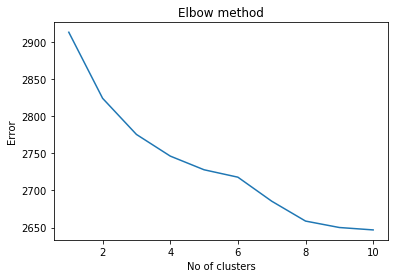

In [61]:
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(X)
    kmeans.fit(X)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

**Now, let's insert the cluster number to each of the cities in the dataframe**

In [62]:
cities_sortedVenues.insert(0, 'Cluster Labels', k_mod.labels_)

**Map the clusters**

In [63]:
# create map
map_clusters = folium.Map(location=[37.0902,-95.7129], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_sortedVenues['Latitude'], cities_sortedVenues['Longitude'], cities_sortedVenues['City'], cities_sortedVenues['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine the Clusters

**Cluster 0**

In [64]:
cities_sortedVenues.loc[cities_sortedVenues['Cluster Labels'] == 0, cities_sortedVenues.columns[[1] + list(range(5, cities_sortedVenues.shape[1]))]]

,City,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
130,"West Palm Beach, FL",39.6,49054.0,5.1,52397.0,2.02,218200.0,10.1,58931.0,44078.0,1.336971,0.473,0.424628,1261.0,27.0,85.8,934.0,0.371512,0.008745,41400.0,2.579831,48.6,21.5,West Palm Beach,Florida,142.7,758,FL,26.7464,-80.1251,Sandwich Place,Clothing Store,American Restaurant,Grocery Store,Asian Restaurant,Convenience Store,Pizza Place,Fast Food Restaurant,Latin American Restaurant,Sports Bar


In [65]:
cities_sortedVenues.loc[cities_sortedVenues['Cluster Labels'] == 1, cities_sortedVenues.columns[[1] + list(range(5, cities_sortedVenues.shape[1]))]]

,City,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Yonkers, NY",38.8,62399.0,1.840,94272.0,2.710,380100.0,0.158,76804.0,59246.0,1.296358,0.499,0.402414,728.0,30.60,87.0,561.0,0.342105,0.002791,74400.0,2.701599,47.3,33.3,Yonkers,New York,46.6,4307,NY,40.9459,-73.8674,Italian Restaurant,Pizza Place,Coffee Shop,Sushi Restaurant,American Restaurant,Grocery Store,Mexican Restaurant,Cosmetics Shop,Sandwich Place,Clothing Store
4,"San Diego, CA",35.4,79646.0,3.890,715998.0,-0.985,654700.0,9.060,78575.0,62298.0,1.261276,0.499,0.402414,1274.0,25.80,87.8,51571.0,0.694575,0.036064,514000.0,2.782101,46.8,22.5,San Diego,California,842.3,1670,CA,32.8153,-117.1350,Japanese Restaurant,Sandwich Place,Mexican Restaurant,Coffee Shop,Grocery Store,Sushi Restaurant,Bubble Tea Shop,Noodle House,Bakery,Fast Food Restaurant
5,"San Jose, CA",37.0,113036.0,7.990,544945.0,0.219,968500.0,13.300,78575.0,62298.0,1.261276,0.499,0.402414,973.0,39.00,83.1,12445.0,0.783718,0.012083,328000.0,3.140244,55.3,29.7,San Jose,California,459.7,2231,CA,37.2967,-121.8189,Vietnamese Restaurant,Bubble Tea Shop,Mexican Restaurant,Pizza Place,Park,Fast Food Restaurant,Seafood Restaurant,Coffee Shop,Gym,Grocery Store
8,"Long Beach, CA",35.8,61610.0,1.740,238174.0,3.010,600700.0,7.710,78575.0,62298.0,1.261276,0.499,0.402414,1391.0,26.00,88.5,13702.0,0.745033,0.029318,173000.0,2.701462,40.8,29.4,Long Beach,California,130.3,3609,CA,33.8092,-118.1553,Mexican Restaurant,Fast Food Restaurant,Sushi Restaurant,Park,Brewery,Diner,American Restaurant,Thai Restaurant,Grocery Store,Taco Place
11,"Anaheim, CA",34.4,76154.0,8.180,180144.0,2.320,606600.0,5.040,78575.0,62298.0,1.261276,0.499,0.402414,1053.0,36.40,81.6,2895.0,0.860540,0.008224,102000.0,3.451157,48.4,27.8,Anaheim,California,129.5,2711,CA,33.8555,-117.7601,American Restaurant,Mexican Restaurant,Grocery Store,Coffee Shop,Park,Sandwich Place,Seafood Restaurant,Pizza Place,Fast Food Restaurant,Mediterranean Restaurant
14,"Stockton, CA",32.8,54297.0,5.770,128717.0,-1.500,299800.0,6.310,78575.0,62298.0,1.261276,0.499,0.402414,1697.0,25.70,86.8,7346.0,0.615215,0.023606,95600.0,3.255115,44.1,33.7,Stockton,California,159.8,1922,CA,37.9763,-121.3133,Coffee Shop,American Restaurant,Bakery,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Mexican Restaurant,Theater,Discount Store,Bar
15,"Irvine, CA",34.4,95573.0,1.870,124407.0,3.580,753400.0,4.810,72235.0,57252.0,1.261703,0.500,0.000000,1053.0,39.60,81.7,18053.0,0.764884,0.070279,92900.0,2.765091,48.2,23.3,Irvine,California,169.9,1566,CA,33.6784,-117.7713,Park,Coffee Shop,Grocery Store,Burger Joint,Pizza Place,Clothing Store,Dessert Shop,Sandwich Place,Candy Store,Korean Restaurant
16,"Chula Vista, CA",34.6,86082.0,11.400,126543.0,6.400,532700.0,7.010,78575.0,62298.0,1.261276,0.499,0.402414,1274.0,30.80,87.7,3670.0,0.523454,0.013510,78100.0,3.478271,58.2,29.7,Chula Vista,California,128.5,2080,CA,32.6277,-117.0152,Mexican Restaurant,Park,Grocery Store,Pharmacy,Coffee Shop,Seafood Restaurant,Chinese Restaurant,Supermarket,Sushi Restaurant,Frozen Yogurt Shop
17,"Fremont, CA",37.7,122191.0,9.480,116110.0,2.750,785700.0,11.800,72235.0,57252.0,1.261703,0.500,0.000000,953.0,47.50,78.7,2395.0,0.545161,0.010370,73600.0,3.138098,62.4,31.7,Fremont,California,200.7,1161,CA,37.4945,-121.9412,Trail,Pizza Place,Gym,Fast 

In [66]:
cities_sortedVenues.loc[cities_sortedVenues['Cluster Labels'] == 2, cities_sortedVenues.columns[[1] + list(range(5, cities_sortedVenues.shape[1]))]]

,City,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
81,"Arlington, TX",33.1,63091.0,10.500,211698.0,7.5500,188800.0,12.500,67436.0,48835.0,1.380895,0.479,0.000000,1758.0,20.60,89.5,13905.0,0.566408,0.034926,136000.0,2.927368,54.6,25.9,Arlington,Texas,248.1,1600,TX,32.7007,-97.1247,American Restaurant,Mexican Restaurant,Sandwich Place,Coffee Shop,Fast Food Restaurant,Park,Pizza Place,Bookstore,Chinese Restaurant,Asian Restaurant
83,"Garland, TX",34.5,55637.0,4.540,114112.0,0.9160,132600.0,9.230,64953.0,45959.0,1.413281,0.482,0.000000,1476.0,28.20,82.8,923.0,0.417819,0.003912,75800.0,3.112995,61.9,27.6,Garland,Texas,147.6,1592,TX,32.9098,-96.6303,Discount Store,American Restaurant,Burger Joint,Gym / Fitness Center,Grocery Store,Chinese Restaurant,BBQ Joint,Mexican Restaurant,Hardware Store,Convenience Store
86,"McKinney, TX",35.0,87608.0,5.230,82370.0,5.4800,255300.0,11.700,64953.0,45959.0,1.413281,0.482,0.000000,1064.0,14.70,91.2,3407.0,0.686634,0.020679,56400.0,2.921277,66.6,26.7,McKinney,Texas,163.2,1056,TX,33.1985,-96.6680,Burger Joint,Sandwich Place,Coffee Shop,Pizza Place,Mexican Restaurant,Deli / Bodega,Steakhouse,Supermarket,Gym,Café
89,"Pasadena, TX",31.3,50207.0,3.290,66038.0,0.0394,108700.0,4.020,64953.0,45959.0,1.413281,0.482,0.000000,1749.0,25.90,82.1,10301.0,0.888013,0.066929,48900.0,3.147423,53.3,25.5,Pasadena,Texas,112.7,1361,TX,29.6586,-95.1506,Mexican Restaurant,Coffee Shop,Burger Joint,Cosmetics Shop,Fast Food Restaurant,Pizza Place,Discount Store,Wings Joint,Bakery,Ice Cream Shop
92,"Mesquite, TX",32.8,52167.0,2.680,69482.0,-0.0230,119000.0,5.870,64953.0,45959.0,1.413281,0.482,0.000000,1476.0,18.60,87.5,1785.0,0.760355,0.012386,46900.0,3.072878,57.7,30.6,Mesquite,Texas,122.2,1176,TX,32.7629,-96.5888,Convenience Store,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Pizza Place,Discount Store,Grocery Store,Ice Cream Shop,Pharmacy,Park
95,"Round Rock, TX",33.9,76295.0,2.980,60906.0,4.3500,210800.0,9.510,64953.0,45959.0,1.413281,0.482,0.000000,1509.0,13.90,92.4,261.0,0.977273,0.002243,37300.0,3.119812,62.4,23.4,Round Rock,Texas,92.2,1311,TX,30.5252,-97.6660,American Restaurant,Coffee Shop,Mexican Restaurant,Burger Joint,Gym,Grocery Store,Fast Food Restaurant,Pizza Place,Sandwich Place,Chinese Restaurant
99,"Beaumont, TX",34.3,45268.0,6.780,52496.0,1.8200,99800.0,0.000,64953.0,45959.0,1.413281,0.482,0.000000,1684.0,10.40,92.8,5734.0,0.630367,0.048419,46200.0,2.563290,56.3,18.2,Beaumont,Texas,212.6,556,TX,30.0849,-94.1453,Mexican Restaurant,Sandwich Place,Bakery,Italian Restaurant,Deli / Bodega,Burger Joint,Pizza Place,Fast Food Restaurant,Steakhouse,American Restaurant
101,"Lewisville, TX",32.6,59964.0,4.200,58819.0,3.2700,172100.0,6.430,64953.0,45959.0,1.413281,0.482,0.000000,1564.0,21.90,85.5,72.0,0.043478,0.000695,38700.0,2.677984,42.6,25.1,Lewisville,Texas,95.1,1101,TX,33.0466,-96.9818,Mexican Restaurant,American Restaurant,Convenience Store,Café,Pizza Place,Fast Food Restaurant,Park,Coffee Shop,Breakfast Spot,Taco Place
102,"League City, TX",34.6,100996.0,4.030,50908.0,1.7300,218900.0,8.370,64953.0,45959.0,1.413281,0.482,0.000000,1395.0,8.94,96.3,0.0,1.000000,NaN,34500.0,2.846812,72.7,29.3,League City,Texas,132.6,769,TX,29.4901,-95.1091,Mexican Restaurant,Burger Joint,Coffee Shop,BBQ Joint,Park,Pharmacy,American Restaurant,Ba

In [67]:
cities_sortedVenues.loc[cities_sortedVenues['Cluster Labels'] == 3, cities_sortedVenues.columns[[1] + list(range(5, cities_sortedVenues.shape[1]))]]

,City,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,"Bakersfield, CA",31.6,60002.0,5.070,166626.0,6.740,257200.0,7.300,78575.0,62298.0,1.261276,0.499,0.402414,2037.0,18.30,90.8,5643.0,0.512463,0.014711,122000.0,3.144270,59.2,21.8,Bakersfield,California,385.4,976,CA,35.3212,-119.0183,Pizza Place,Mexican Restaurant,Fast Food Restaurant,Coffee Shop,Sandwich Place,Burger Joint,Cosmetics Shop,Clothing Store,American Restaurant,Chinese Restaurant
18,"San Bernardino, CA",29.4,41027.0,6.690,78721.0,2.600,202100.0,14.300,72235.0,57252.0,1.261703,0.500,0.000000,1752.0,23.60,85.0,7307.0,0.607347,0.033946,58000.0,3.711241,46.8,26.7,San Bernardino,California,159.3,1358,CA,34.1416,-117.2936,Sandwich Place,Fast Food Restaurant,Mexican Restaurant,Pizza Place,Discount Store,Coffee Shop,Grocery Store,Burger Joint,Bank,Video Store
19,"Fontana, CA",30.6,68304.0,3.500,92883.0,3.790,323300.0,11.700,72235.0,57252.0,1.261703,0.500,0.000000,1752.0,27.40,85.7,32.0,0.032258,0.000155,51900.0,3.990096,64.4,31.5,Fontana,California,111.4,1883,CA,34.1090,-117.4629,Mexican Restaurant,Fast Food Restaurant,Grocery Store,American Restaurant,Racetrack,Convenience Store,Sandwich Place,Burger Joint,Frozen Yogurt Shop,Coffee Shop
22,"Moreno Valley, CA",30.3,59827.0,5.970,85889.0,2.550,260600.0,12.600,72235.0,57252.0,1.261703,0.500,0.000000,2380.0,24.50,87.7,1510.0,0.564767,0.007413,50800.0,4.009665,60.5,33.2,Moreno Valley,California,132.9,1547,CA,33.9233,-117.2057,Fast Food Restaurant,Pizza Place,Coffee Shop,Mexican Restaurant,Pharmacy,Convenience Store,Sandwich Place,Grocery Store,Chinese Restaurant,American Restaurant
25,"Ontario, CA",32.0,57544.0,4.820,79115.0,2.780,320000.0,9.220,72235.0,57252.0,1.261703,0.500,0.000000,1752.0,27.60,84.1,1914.0,0.333798,0.011190,49200.0,3.476443,53.5,29.7,Ontario,California,129.2,1340,CA,34.0394,-117.6042,Mexican Restaurant,Fast Food Restaurant,Sandwich Place,Coffee Shop,Hotel,Pizza Place,Burger Joint,Pharmacy,Convenience Store,Japanese Restaurant
28,"Oceanside, CA",37.5,61778.0,4.800,80261.0,2.440,423100.0,10.200,72235.0,57252.0,1.261703,0.500,0.000000,1274.0,19.90,90.5,2535.0,0.585366,0.014501,62000.0,2.819532,56.0,26.8,Oceanside,California,107,1641,CA,33.2245,-117.3062,Fast Food Restaurant,Mexican Restaurant,Pizza Place,Coffee Shop,Convenience Store,Grocery Store,Park,Restaurant,Brewery,Sports Bar
33,"Lancaster, CA",32.4,49314.0,3.420,56062.0,1.330,213100.0,14.600,72235.0,57252.0,1.261703,0.500,0.000000,1391.0,11.70,94.9,3781.0,0.547054,0.023615,48100.0,3.328753,53.8,30.8,Lancaster,California,244.2,656,CA,34.6936,-118.1753,Sandwich Place,Mexican Restaurant,Coffee Shop,Pharmacy,Fast Food Restaurant,American Restaurant,Sushi Restaurant,Gym / Fitness Center,Pizza Place,Café
34,"Palmdale, CA",31.3,56699.0,7.380,60344.0,2.920,229200.0,10.500,72235.0,57252.0,1.261703,0.500,0.000000,1391.0,25.30,88.3,0.0,1.000000,NaN,44100.0,3.568209,64.0,40.6,Palmdale,California,274.5,573,CA,34.5910,-118.1054,Fast Food Restaurant,Convenience Store,Coffee Shop,Discount Store,Sandwich Place,Thai Restaurant,Pizza Place,Grocery Store,Sushi Restaurant,Mexican Restaurant
42,"Roseville, CA",38.5,81119.0,3.410,61692.0,2.330,386300.0,8.540,72235.0,57252.0,1.261703,0.500,0.000000,836.0,12.90,95.5,11.0,4.500000,0.000084,47900.0,2.728706,64.7,23.7,Roseville,California,111.4,1191,CA

In [68]:
cities_sortedVenues.loc[cities_sortedVenues['Cluster Labels'] == 4, cities_sortedVenues.columns[[1] + list(range(5, cities_sortedVenues.shape[1]))]]

,City,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
77,"San Antonio, TX",33.7,49024.0,-2.0400,716405.0,1.42000,155600.0,4.9900,67436.0,48835.0,1.380895,0.479,0.000000,1370.0,13.70,90.9,32538.0,0.744758,0.021267,510000.0,3.000000,53.0,23.8,San Antonio,Texas,1194,1250,TX,29.472400,-98.525100,Burger Joint,Mexican Restaurant,Coffee Shop,Park,Pizza Place,Grocery Store,Bar,BBQ Joint,Cosmetics Shop,Taco Place
80,"Fort Worth, TX",33.2,58448.0,-2.9200,425825.0,-1.00000,189300.0,11.7000,67436.0,48835.0,1.380895,0.479,0.000000,1758.0,16.10,89.1,13869.0,0.641496,0.015429,308000.0,2.918568,56.4,26.7,Fort Worth,Texas,888.1,962,TX,32.781500,-97.346700,Mexican Restaurant,Bar,Steakhouse,Burger Joint,Hotel,New American Restaurant,Art Museum,Ice Cream Shop,Sushi Restaurant,Beer Bar
91,"McAllen, TX",32.9,45057.0,-1.1200,58587.0,1.59000,120500.0,2.5500,64953.0,45959.0,1.413281,0.482,0.000000,2228.0,27.40,82.8,7040.0,0.628876,0.050344,44000.0,3.178136,59.6,19.1,McAllen,Texas,151.3,940,TX,26.232200,-98.246400,Mexican Restaurant,Café,Park,Grocery Store,Bakery,American Restaurant,Coffee Shop,Breakfast Spot,Deli / Bodega,Burger Joint
93,"Denton, TX",29.1,52164.0,3.3200,67369.0,3.11000,179000.0,10.0000,64953.0,45959.0,1.413281,0.482,0.000000,1564.0,13.30,90.7,13201.0,0.501649,0.100696,45900.0,2.856144,47.8,22.7,Denton,Texas,241.9,553,TX,33.216600,-97.141400,Coffee Shop,Fast Food Restaurant,Mexican Restaurant,Burger Joint,American Restaurant,Breakfast Spot,BBQ Joint,Pizza Place,Brewery,Mediterranean Restaurant
121,"Fort Lauderdale, FL",42.2,52315.0,1.2900,89799.0,2.50000,297200.0,8.7100,58931.0,44078.0,1.336971,0.473,0.424628,1383.0,23.80,88.3,18061.0,0.648052,0.101939,73700.0,2.404003,52.4,24.6,Fort Lauderdale,Florida,89.6,1995,FL,26.141200,-80.146700,Beach,Grocery Store,American Restaurant,Hotel,Seafood Restaurant,Bar,Italian Restaurant,Nightclub,Coffee Shop,Pizza Place
131,"Lakeland, FL",41.3,42033.0,2.7200,42578.0,4.32000,119700.0,9.5200,58931.0,44078.0,1.336971,0.473,0.424628,2044.0,9.59,94.9,1812.0,0.567474,0.017395,40400.0,2.578342,56.3,20.0,Lakeland,Florida,170.7,624,FL,28.055500,-81.954900,American Restaurant,Sandwich Place,BBQ Joint,Park,Coffee Shop,Fast Food Restaurant,Clothing Store,Steakhouse,Cosmetics Shop,Food Truck
135,"Charlotte, NC",34.7,60764.0,-0.9550,472775.0,1.79000,230900.0,7.1500,62551.0,47552.0,1.315423,0.470,-0.634249,1150.0,15.80,88.8,12984.0,0.703713,0.014881,336000.0,2.596744,52.5,23.8,Charlotte,North Carolina,791,1064,NC,35.207800,-80.831000,Park,Brewery,American Restaurant,Bakery,Mexican Restaurant,Italian Restaurant,Pizza Place,Sandwich Place,Burger Joint,Theater
137,"Greensboro, NC",35.6,45787.0,-2.6700,139287.0,-2.64000,156600.0,-0.2550,62551.0,47552.0,1.315423,0.470,-0.634249,1241.0,10.30,92.9,7384.0,0.541545,0.025054,120000.0,2.456050,48.4,19.8,Greensboro,North Carolina,332.3,864,NC,36.095100,-79.827000,Coffee Shop,American Restaurant,Pizza Place,Grocery Store,Italian Restaurant,Steakhouse,Cosmetics Shop,Burger Joint,Garden,Sandwich Place
141,"Evansville, IN",37.2,36956.0,1.7200,55708.0,-0.36000,89700.0,0.1120,59508.0,42677.0,1.394381,0.456,-0.218818,1130.0,2.67,98.3,776.0,0.455910,0.006477,51600.0,2.321822,54.5,18.4,Evansville,Indiana,122.5,975,IN,37.987700,-87.534700,Pizza Place,Bar,Ice Cream Shop,Italian Restaurant,Chinese Restaurant,Coffe

In [69]:
cities_sortedVenues.loc[cities_sortedVenues['Cluster Labels'] == 5, cities_sortedVenues.columns[[1] + list(range(5, cities_sortedVenues.shape[1]))]]

,City,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"New York, NY",36.9,63799.0,4.8,4090000.0,-2.21,645100.0,5.84,81735.0,63914.0,1.278828,0.493,-0.804829,1553.0,36.9,84.3,147053.0,0.608367,0.017506,3180000.0,2.641509,32.8,40.1,New York,New York,780.9,10933,NY,40.6635,-73.9387,Bar,Caribbean Restaurant,Café,Bakery,Coffee Shop,Park,New American Restaurant,Wine Shop,Beer Bar,Pizza Place


In [70]:
cities_sortedVenues.loc[cities_sortedVenues['Cluster Labels'] == 6, cities_sortedVenues.columns[[1] + list(range(5, cities_sortedVenues.shape[1]))]]

,City,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"Los Angeles, CA",35.8,62474.0,3.780,2060000.0,0.509,682400.0,5.470,78575.0,62298.0,1.261276,0.499,0.402414,1391.0,37.10,80.7,78532.0,0.691261,0.019682,1380000.0,2.891304,36.3,30.3,Los Angeles,California,1213.9,3276,CA,34.0194,-118.4108,Grocery Store,Coffee Shop,Mexican Restaurant,Japanese Restaurant,New American Restaurant,Taco Place,Ice Cream Shop,American Restaurant,Bakery,Wine Shop
6,"San Francisco, CA",38.3,112376.0,1.410,536653.0,0.392,1200000.0,8.300,78575.0,62298.0,1.261276,0.499,0.402414,631.0,34.00,87.6,20817.0,0.640684,0.023567,363000.0,2.433347,37.6,30.9,San Francisco,California,121.5,7170,CA,37.7272,-123.0322,Outdoors & Recreation,Zoo Exhibit,Driving School,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service
7,"Sacramento, CA",34.3,65046.0,14.200,239523.0,2.480,358300.0,6.670,78575.0,62298.0,1.261276,0.499,0.402414,1227.0,22.10,89.8,12549.0,0.779495,0.024678,183000.0,2.778781,49.1,24.8,Sacramento,California,253.6,1953,CA,38.5666,-121.4686,Coffee Shop,American Restaurant,Park,Sandwich Place,Bar,Mexican Restaurant,Sushi Restaurant,Bakery,New American Restaurant,Hotel
9,"Oakland, CA",36.8,76469.0,8.350,235825.0,4.830,717700.0,4.510,78575.0,62298.0,1.261276,0.499,0.402414,953.0,27.10,87.5,4001.0,0.423843,0.009324,166000.0,2.585024,41.3,31.1,Oakland,California,144.8,2901,CA,37.7698,-122.2257,Grocery Store,Mexican Restaurant,Park,Bakery,Coffee Shop,Farmers Market,Thai Restaurant,Pizza Place,Beach,Brewery
12,"Santa Ana, CA",32.0,65313.0,-0.521,164903.0,-3.020,534600.0,8.070,78575.0,62298.0,1.261276,0.499,0.402414,1053.0,45.30,76.3,5746.0,0.686033,0.017269,78800.0,4.222424,44.8,24.8,Santa Ana,California,70.2,4762,CA,33.7363,-117.8830,Coffee Shop,Mexican Restaurant,American Restaurant,Café,Grocery Store,Sandwich Place,Fast Food Restaurant,Diner,Italian Restaurant,Seafood Restaurant
13,"Riverside, CA",31.2,67850.0,1.380,156254.0,1.680,385000.0,4.450,78575.0,62298.0,1.261276,0.499,0.402414,2380.0,22.20,90.4,13042.0,0.684143,0.039512,87300.0,3.780985,55.0,28.9,Riverside,California,210.3,1544,CA,33.9381,-117.3932,Grocery Store,Coffee Shop,Fast Food Restaurant,Park,Outdoors & Recreation,Garden Center,Golf Course,Bakery,Sandwich Place,Gastropub
27,"Santa Rosa, CA",38.1,67144.0,7.080,85815.0,1.790,458500.0,10.500,72235.0,57252.0,1.261703,0.500,0.000000,1002.0,19.40,88.8,4922.0,0.968800,0.028248,64700.0,2.693107,53.1,21.4,Santa Rosa,California,107,1637,CA,38.4468,-122.7061,Coffee Shop,Mexican Restaurant,Thai Restaurant,Italian Restaurant,Grocery Store,Brewery,Café,Pizza Place,American Restaurant,Bakery
35,"Sunnyvale, CA",35.6,118314.0,7.760,80610.0,3.450,968700.0,12.800,72235.0,57252.0,1.261703,0.500,0.000000,973.0,47.30,70.8,65.0,0.911765,0.000429,55700.0,2.721095,46.7,23.3,Sunnyvale,California,57,2681,CA,37.3858,-122.0263,Grocery Store,Park,Burger Joint,Mexican Restaurant,Pizza Place,Indian Restaurant,Fast Food Restaurant,Gym / Fitness Center,Coffee Shop,Farmers Market
36,"Pomona, CA",31.5,53281.0,5.800,66841.0,3.470,344200.0,11.000,72235.0,57252.0,1.261703,0.500,0.000000,1391.0,34.10,80.1,8657.0,1.012320,0.056817,38900.0,3.916864,52.6,29.0,Pomona,California,59.6,2560,CA,34.0585,-117.7611,Mexican Restaurant,

In [71]:
cities_sortedVenues.loc[cities_sortedVenues['Cluster Labels'] == 7, cities_sortedVenues.columns[[1] + list(range(5, cities_sortedVenues.shape[1]))]]

,City,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Buffalo, NY",33.3,37359.0,7.310,114478.0,-4.780,98300.0,6.040,81735.0,63914.0,1.278828,0.493,-0.804829,1243.0,9.49,93.9,8053.0,0.684376,0.031418,109000.0,2.351578,41.6,18.9,Buffalo,New York,104.6,2455,NY,42.8925,-78.8597,Brewery,New American Restaurant,Market,Coffee Shop,Food Truck,Italian Restaurant,Bakery,Plaza,Greek Restaurant,Cocktail Bar
113,"Philadelphia, PA",34.5,46116.0,16.000,714190.0,6.010,167700.0,0.903,69779.0,52119.0,1.338840,0.469,-0.635593,1458.0,13.30,92.8,41499.0,0.736869,0.026265,608000.0,2.598684,52.7,33.0,Philadelphia,Pennsylvania,347.6,4511,PA,40.0094,-75.1333,Bar,Café,Caribbean Restaurant,Convenience Store,Brewery,Donut Shop,Bakery,Breakfast Spot,Gym,Liquor Store
114,"Allentown, PA",31.8,38522.0,3.400,50125.0,0.441,124000.0,-1.670,67039.0,49502.0,1.354269,0.469,0.000000,1039.0,17.40,91.1,1332.0,0.374613,0.011088,41900.0,2.867017,43.4,22.6,Allentown,Pennsylvania,45.3,2657,PA,40.5936,-75.4784,Park,Italian Restaurant,Ice Cream Shop,Diner,Pizza Place,Convenience Store,American Restaurant,Bar,Pub,Farmers Market
116,"Tampa, FL",34.6,54599.0,8.140,191406.0,-0.721,257600.0,10.200,62257.0,46612.0,1.335643,0.474,0.211416,1189.0,15.50,91.5,30419.0,0.477798,0.077421,154000.0,2.551331,48.3,23.7,Tampa,Florida,293.7,1284,FL,27.9701,-82.4797,American Restaurant,Coffee Shop,Pizza Place,Park,Theater,Sandwich Place,Brewery,New American Restaurant,Spanish Restaurant,Scenic Lookout
126,"Clearwater, FL",44.1,45631.0,2.380,51435.0,2.170,172900.0,5.750,58931.0,44078.0,1.336971,0.473,0.424628,1093.0,15.00,92.8,353.0,0.131410,0.003130,46400.0,2.430905,57.6,22.6,Clearwater,Florida,67.1,1705,FL,27.9789,-82.7666,Grocery Store,Pizza Place,Park,Brewery,American Restaurant,Sandwich Place,Café,Coffee Shop,Italian Restaurant,Fast Food Restaurant
133,"Cleveland, OH",36.3,29953.0,3.380,161102.0,1.190,71100.0,1.280,65155.0,48520.0,1.342848,0.460,0.656455,898.0,5.22,97.2,13139.0,0.805304,0.034236,173000.0,2.218387,40.0,23.5,Cleveland,Ohio,201.2,1917,OH,41.4785,-81.6794,Coffee Shop,Brewery,Theater,Gastropub,Cocktail Bar,Sushi Restaurant,Café,Ice Cream Shop,Bar,American Restaurant
134,"Cincinnati, OH",33.0,43585.0,11.900,149764.0,-2.360,147800.0,3.280,65155.0,48520.0,1.342848,0.460,0.656455,924.0,5.44,96.2,15164.0,0.722008,0.050110,139000.0,2.177086,38.0,22.8,Cincinnati,Ohio,200.5,1490,OH,39.1402,-84.5058,Bar,American Restaurant,Brewery,Pizza Place,Coffee Shop,Park,Bakery,Italian Restaurant,Sandwich Place,Vietnamese Restaurant
138,"Durham, NC",34.1,54840.0,-2.720,150131.0,7.480,232600.0,1.090,62551.0,47552.0,1.315423,0.470,-0.634249,820.0,14.10,90.0,9504.0,0.788483,0.034623,112000.0,2.450866,50.8,21.1,Durham,North Carolina,284.4,925,NC,35.9811,-78.9029,Bakery,Sandwich Place,Coffee Shop,Brewery,Park,Café,Hotel,Bar,Peruvian Restaurant,Asian Restaurant
144,"Spokane, WA",35.8,44768.0,3.450,95885.0,2.340,166700.0,3.670,73040.0,53882.0,1.355555,0.467,0.000000,1131.0,6.24,96.7,5225.0,0.830764,0.024533,88700.0,2.401150,54.7,19.2,Spokane,Washington,177.9,1214,WA,47.6669,-117.4333,Coffee Shop,Hotel,Park,Grocery Store,American Restaurant,Mexican Restaurant,Pizza Place,Garden,Diner,Brewery
145,"Tacoma, WA",35.9,55506.0,3.650,98060.0,1.850,227200.0,6.970,73040.0,53882.0,1.355555,0.467,0.000000,1423.0,12.80,93.9,6063.0,0.698319

### Recommendation System
___
There are different types of basic recommendations systems available. The most common are:
1. Content-based recomenndation
2. Collaborative Filtering
3. Hybrid of Content and Collaborative

Since we do not have information about users, we will create a **content-based** recommendation system that leverages the user's input to weight the variables based on their rating of cities they like.

###### First, lets create a class for a rated city

In [72]:
class rated_city:
    def __init__(self, city, rating):
        self.city = city
        self.rating = rating

##### Second, create a function that takes in the cities the user liked and wants to rate
**Note that city names MUST include the state abbreviation**

    Example: New York, NY 
             Boston, MA

In [73]:
def input_cities():
    add_city = True
    userInput = []
    newrows = []
    cities_all_list = list(cities.City)
    while add_city == True:
        city_name = input("City (Include state - Ex. Boston, MA): ")
        stopper=pd.DataFrame([city_name]).isin(cities_all_list)
        stopper=stopper.iloc[0,0]
        rating = input("What rating yould you give the city (1-10): ")
        city = rated_city(city_name, rating)
        userInput.append(city.__dict__)
        cont = input("Do you want to rate another city?")
        add_city = cont.lower() in ['yes','true','of course','y','si','1']
        if stopper == False:
            list_newcity = city_name.lower().replace(',','').replace(' ','-')
            new_url = "https://datausa.io/profile/geo/"+list_newcity
            try:
                new_data = get_basic_city_info(new_url)
                newrows.append(new_data)
            except:
                pass
    
    inputMovies = pd.DataFrame(userInput)
        
    return(inputMovies)

In [74]:
def input_cities():
    add_city = True
    userInput = []
    while add_city == True:
        city_name = input("City (Include state - Ex. Boston, MA): ")
        rating = input("What rating yould you give the city (1-10): ")
        city = rated_city(city_name, rating)
        userInput.append(city.__dict__)
        cont = input("Do you want to rate another city?")
        add_city = cont.lower() in ['yes','true','of course','y','si','1']
    
    inputMovies = pd.DataFrame(userInput)
        
    return(inputMovies)

In [116]:
inputCities = input_cities()

City (Include state - Ex. Boston, MA): Philadelphia, PA
What rating yould you give the city (1-10): 6
Do you want to rate another city?y
City (Include state - Ex. Boston, MA): Akron, OH
What rating yould you give the city (1-10): 4
Do you want to rate another city?y
City (Include state - Ex. Boston, MA): New York, NY
What rating yould you give the city (1-10): 7
Do you want to rate another city?y
City (Include state - Ex. Boston, MA): Boston, MA
What rating yould you give the city (1-10): 7
Do you want to rate another city?y
City (Include state - Ex. Boston, MA): Chicago, IL
What rating yould you give the city (1-10): 8
Do you want to rate another city?y
City (Include state - Ex. Boston, MA): Syracuse, NY
What rating yould you give the city (1-10): 3
Do you want to rate another city?y
City (Include state - Ex. Boston, MA): Las Vegas, NV
What rating yould you give the city (1-10): 5
Do you want to rate another city?y
City (Include state - Ex. Boston, MA): Durham, NC
What rating yould yo

In [117]:
[float(i)-5 for i in inputCities.rating]

[1.0, -1.0, 2.0, 2.0, 3.0, -2.0, 0.0, 2.0, 1.5]

In [118]:
inputCities

,city,rating
0,"Philadelphia, PA",6
1,"Akron, OH",4
2,"New York, NY",7
3,"Boston, MA",7
4,"Chicago, IL",8
5,"Syracuse, NY",3
6,"Las Vegas, NV",5
7,"Durham, NC",7
8,"Los Angeles, CA",6.5


Before we begin learning the preferences based on the input, let's input city names into the normalized (scaled) data.

In [119]:
norm_df = pd.DataFrame(X)
norm_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519
0,1.000000,0.000000,0.462555,0.637255,0.366942,0.500891,1.000000,0.119646,0.516806,0.525487,0.580772,0.577134,0.152606,0.849315,0.394921,0.305298,0.485456,0.553314,1.000000,0.088027,0.054076,1.000000,0.168355,0.181667,0.882353,0.398239,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.142857,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.5,0.0,0.538462,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.833333,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.357143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.142857,0.0,0.5,0.0,0.00,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.00,0.0,0.0,0.5,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.5,0.166667,0.000000,0.0,0.0,0.0,0.666667,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.000000,0.0,0.5,0.0,0.000000,0.090909,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.125,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444444,0.0,0.0,0.0,0.0,0.5,1.0,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.3,0.0,0.0,0.333333,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0

In [120]:
names_norm = list(usa_cluster_predictors.columns)

In [121]:
names_norm_dict = {}
for i in range(0,len(names_norm)):
    names_norm_dict[i]=names_norm[i]

In [122]:
norm_df=norm_df.rename(columns=names_norm_dict)
norm_df.head()

,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,Land_Area_km2,Population_Density_per_km2,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Chaat Place,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cidery,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Engineering Building,College Football Field,College Gym,College Hockey Rink,College Library,College Quad,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Courthouse,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donburi Restaurant,Donut Shop,Dosa Place,Drive-in Theater,Driving School,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah B

In [123]:
norm_df.insert(0, 'City', cities_one_hot.City)
norm_df.insert(0, 'Cluster Labels', k_mod.labels_)
norm_df.head()

,Cluster Labels,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,Land_Area_km2,Population_Density_per_km2,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Castle,Chaat Place,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cidery,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Engineering Building,College Football Field,College Gym,College Hockey Rink,College Library,College Quad,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Courthouse,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donburi Restaurant,Donut Shop,Dosa Place,Drive-in Theater,Driving School,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong

In [124]:
#Get the dummy variables for each cluster
recom_dummies = pd.get_dummies(norm_df[['Cluster Labels']].astype(str), prefix="", prefix_sep="")

#Add name of city to dataframe
recom_dummies['City'] = norm_df['City']

#Lets make it readable by changing the location of the City column to be the first column of the dataframe
move_column = [recom_dummies.columns[-1]] + list(recom_dummies.columns[:-1])
recom_dummies = recom_dummies[move_column]

print(recom_dummies.shape)
recom_dummies.head()
recom_dummies = recom_dummies.rename(columns={'0':'Cluster 0','1':'Cluster 1','2':'Cluster 2','3':'Cluster 3','4':'Cluster 4','5':'Cluster 5','6':'Cluster 6','7':'Cluster 7'})

(298, 9)


In [125]:
norm_df = norm_df.merge(recom_dummies, on='City')

Above, we added the cities and cluster labels to the normalized dataframe.

Now we can begin learning the preferences based on the input.

In [126]:
userCities = norm_df[norm_df['City'].isin(inputCities['city'].tolist())]

userCities = userCities.reset_index(drop=True)
cityCluster_df = userCities[['Cluster Labels','City']]
userCities = userCities.drop('Cluster Labels',1).drop('City',1)

In [127]:
userProfile = userCities.transpose().dot(inputCities['rating'].astype(float))

In [128]:
prerecommend_df = norm_df.drop('Cluster Labels',1).drop('City',1)

In [129]:
recommendation_df = ((prerecommend_df*userProfile).sum(axis=1))/userProfile.sum()
recommendation_df = recommendation_df.sort_values(ascending=False)
recommendation_df.head(10)

0      0.315096
113    0.271652
138    0.248822
3      0.248368
248    0.241647
250    0.239588
235    0.238457
162    0.237936
7      0.236938
160    0.236488
dtype: float64

In [130]:
def top_X(num):
    newdf = pd.DataFrame(recommendation_df.head(num))
    indexValues = newdf.index.values
    listindex = list(indexValues)
    resultCities = cities_sortedVenues.reindex(listindex)
    resultCities = resultCities[~resultCities.City.isin(inputCities.city)]
    return(resultCities)
top_X(20)

,Cluster Labels,City,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,City Name,State,Land_Area_km2,Population_Density_per_km2,State_Abb,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
235,7,"Richmond, VA",1300000.0,0.1600,12.4,38.8,67703.0,0.103,658555.0,1.150,246100.0,3.45,77546.0,58156.0,1.333414,0.480,0.628931,1316.0,7.23,95.6,16092.0,0.637363,0.012378,497000.0,2.615694,65.6,23.7,Richmond,Virginia,154.9,1441,VA,37.5314,-77.4760,Park,Coffee Shop,Pizza Place,American Restaurant,Grocery Store,Sandwich Place,New American Restaurant,Seafood Restaurant,Brewery,Farmers Market
162,6,"Cambridge, MA",110893.0,1.9600,13.5,30.4,89145.0,7.250,65165.0,2.560,670200.0,6.43,84043.0,62850.0,1.337200,0.485,0.000000,788.0,28.30,82.1,15420.0,1.010168,0.139053,44200.0,2.508891,36.2,23.7,Cambridge,Massachusetts,16.6,6675,MA,42.3760,-71.1187,Bakery,Café,Pizza Place,New American Restaurant,Vegetarian / Vegan Restaurant,Gym,Coffee Shop,Brewery,Park,Sandwich Place
7,6,"Sacramento, CA",508517.0,1.3200,19.8,34.3,65046.0,14.200,239523.0,2.480,358300.0,6.67,78575.0,62298.0,1.261276,0.499,0.402414,1227.0,22.10,89.8,12549.0,0.779495,0.024678,183000.0,2.778781,49.1,24.8,Sacramento,California,253.6,1953,CA,38.5666,-121.4686,Coffee Shop,American Restaurant,Park,Sandwich Place,Bar,Mexican Restaurant,Sushi Restaurant,Bakery,New American Restaurant,Hotel
208,7,"Jersey City, NJ",265560.0,-1.9200,18.7,34.2,72561.0,9.500,141780.0,1.060,416900.0,9.74,89489.0,65578.0,1.364619,0.493,0.000000,1923.0,41.00,77.6,4172.0,0.527086,0.015710,102000.0,2.603529,29.6,37.0,Jersey City,New Jersey,38.3,6891,NJ,40.7114,-74.0648,Park,Coffee Shop,Bakery,Café,Waterfront,Pizza Place,Bagel Shop,Ice Cream Shop,Plaza,Mexican Restaurant
192,7,"St. Louis, MO",302838.0,-1.8800,25.0,36.4,43889.0,5.910,158338.0,0.944,154800.0,9.48,63351.0,46612.0,1.359114,0.461,0.217391,1178.0,6.89,96.5,7924.0,0.694973,0.026166,144000.0,2.103042,43.7,24.4,St. Louis,Missouri,160.6,1939,MO,38.6357,-90.2446,Brewery,Coffee Shop,New American Restaurant,Bar,Sandwich Place,Southern / Soul Food Restaurant,Wine Bar,Pizza Place,Ice Cream Shop,Grocery Store
231,7,"Pittsburgh, PA",2320000.0,-0.3700,11.8,43.1,59710.0,2.030,1170000.0,0.509,160300.0,4.57,69779.0,52119.0,1.338840,0.469,-0.635593,1232.0,3.78,98.2,39982.0,0.763030,0.017234,1010000.0,2.297030,69.6,25.4,Pittsburgh,Pennsylvania,143.5,2116,PA,40.4398,-79.9766,Hotel,Bar,American Restaurant,Theater,Restaurant,Coffee Shop,Italian Restaurant,History Museum,Vegetarian / Vegan Restaurant,Sandwich Place
233,7,"Jacksonville, FL",1530000.0,1.9700,13.9,38.8,60238.0,2.600,727956.0,2.880,217200.0,5.90,62257.0,46612.0,1.335643,0.474,0.211416,1376.0,8.44,95.8,18224.0,0.709087,0.011911,575000.0,2.660870,63.5,25.2,Jacksonville,Florida,1935.8,455,FL,30.3369,-81.6616,Park,Sandwich Place,Coffee Shop,Brewery,Bar,American Restaurant,Restaurant,Food Truck,Concert Hall,Café
164,4,"Detroit, MI",672681.0,-0.0627,37.9,35.0,31283.0,3.090,249478.0,6.570,51600.0,2.79,66961.0,48599.0,1.377827,0.472,-0.211416,1470.0,5.81,95.2,11564.0,0.685960,0.017191,266000.0,2.528876,46.8,24.9,Detroit,Michigan,359.5,1871,MI,42.3830,-83.1022,Bar,Middle Eastern Restaurant,Pharmacy,Pizza Place,Bakery,American Restaurant,Fast Food Restaurant,History Museum,Discount Store,Art Museum
1,7,"Buffalo, NY",256322.0,-0.8780,30.9,33.3,37359.0,7.310,114478.0,-4.780,98300.0,6.04,81735.0,63914.0,1.278828,0.493,-0.804829,124

<h3 id = "ExplorationVariables">Exploration of Varibles</h3>

This next section is meant for observing and describing the different variables and their relationships.

While this doesn't influence the subsequent sections, it's ineresting to visualize and see the intricacies of relationships between variables in different cities! Feel free to snoop around.

In [244]:
onlyContinuous = ['Population', 'Population Change', 'Poverty Rate',
       'Median Age', 'Median Household Income',
       'Median Household Income Change', 'Number Employees',
       'Number Employees Change', 'Median Property Value',
       'Median Property Value Change', 'Average Male Salary',
       'Average Female Salary', 'Gender Salary Ratio M2F', 'Gini 2018',
       'Gini Change', 'Patient to Clinician Ratio',
       'Foreign Born Population Ratio', 'Citizens Percentage',
       'Total Degrees', 'Degrees Ratio M2F', 'Degrees per Capita',
       'Households', 'People Per House', 'Homeownership', 'Commute Time','Land_Area_km2',
       'Population_Density_per_km2']
onlyCon_df = cities[onlyContinuous]
print(onlyCon_df.shape)
onlyCon_df.head()

(299, 27)


,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time,Land_Area_km2,Population_Density_per_km2
0,8400000.0,-2.600,19.6,36.9,63799.0,4.80,4090000.0,-2.210,645100.0,5.840,81735.0,63914.0,1.278828,0.493,-0.804829,1553.0,36.90,84.3,147053.0,0.608367,0.017506,3180000.0,2.641509,32.8,40.1,780.9,10933
1,256322.0,-0.878,30.9,33.3,37359.0,7.31,114478.0,-4.780,98300.0,6.040,81735.0,63914.0,1.278828,0.493,-0.804829,1243.0,9.49,93.9,8053.0,0.684376,0.031418,109000.0,2.351578,41.6,18.9,104.6,2455
2,200999.0,0.638,16.4,38.8,62399.0,1.84,94272.0,2.710,380100.0,0.158,76804.0,59246.0,1.296358,0.499,0.402414,728.0,30.60,87.0,561.0,0.342105,0.002791,74400.0,2.701599,47.3,33.3,46.6,4307
3,3990000.0,-0.232,20.4,35.8,62474.0,3.78,2060000.0,0.509,682400.0,5.470,78575.0,62298.0,1.261276,0.499,0.402414,1391.0,37.10,80.7,78532.0,0.691261,0.019682,1380000.0,2.891304,36.3,30.3,1213.9,3276
4,1430000.0,0.459,14.5,35.4,79646.0,3.89,715998.0,-0.985,654700.0,9.060,78575.0,62298.0,1.261276,0.499,0.402414,1274.0,25.80,87.8,51571.0,0.694575,0.036064,514000.0,2.782101,46.8,22.5,842.3,1670


In [245]:
onlyCon_df.describe()

,Population,Population Change,Poverty Rate,Median Age,Median Household Income,Median Household Income Change,Number Employees,Number Employees Change,Median Property Value,Median Property Value Change,Average Male Salary,Average Female Salary,Gender Salary Ratio M2F,Gini 2018,Gini Change,Patient to Clinician Ratio,Foreign Born Population Ratio,Citizens Percentage,Total Degrees,Degrees Ratio M2F,Degrees per Capita,Households,People Per House,Homeownership,Commute Time
count,2.990000e+02,299.000000,299.000000,299.000000,299.000000,299.000000,2.990000e+02,299.000000,2.990000e+02,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,278.000000,2.990000e+02,299.000000,299.000000,299.000000
mean,3.660734e+05,0.935733,15.955920,35.433110,61990.642140,4.199676,1.786594e+05,1.909012,2.847779e+05,6.407963,68276.284281,51208.575251,1.338823,0.477943,0.034642,1361.464883,17.645619,90.687960,8085.143813,0.710680,0.024717,1.358355e+05,2.824892,56.422074,24.457860
std,6.263302e+05,1.399946,6.265184,3.659869,17720.308115,3.071033,3.099903e+05,2.199517,1.827252e+05,4.022758,7961.623532,7137.320954,0.065596,0.016844,0.775445,396.257206,11.930397,6.195288,13185.264945,0.514670,0.029566,2.372171e+05,0.417079,11.330299,4.675615
min,2.494000e+03,-2.600000,3.850000,17.400000,29953.000000,-6.440000,1.355000e+03,-4.780000,5.160000e+04,-8.180000,53488.000000,37730.000000,1.225980,0.431000,-3.655914,631.000000,1.520000,65.100000,0.000000,0.000000,0.000051,9.740000e+02,2.103042,21.900000,14.600000
25%,1.254115e+05,0.275000,11.400000,33.400000,49986.500000,2.600000,6.031300e+04,0.815000,1.601000e+05,3.280000,62257.000000,45959.000000,1.261703,0.466000,0.000000,1099.000000,7.990000,87.100000,1163.000000,0.546695,0.009126,4.420000e+04,2.551450,48.500000,21.150000
50%,1.820830e+05,0.798000,15.600000,35.200000,58603.000000,4.170000,8.617700e+04,1.850000,2.309000e+05,6.580000,67436.000000,48835.000000,1.336971,0.478000,0.000000,1307.000000,14.700000,92.100000,4342.000000,0.685960,0.017386,6.820000e+04,2.716687,57.000000,23.700000
75%,3.854375e+05,1.410000,19.450000,37.550000,71601.500000,5.870000,1.827615e+05,2.860000,3.405000e+05,9.225000,72235.000000,57252.000000,1.379856,0.499000,0.402414,1514.000000,25.800000,95.700000,10613.500000,0.807235,0.029672,1.430000e+05,2.996719,64.600000,27.100000
max,8.400000e+06,16.200000,37.900000,48.000000,122191.000000,16.000000,4.090000e+06,16.700000,1.200000e+06,18.500000,102125.000000,83099.000000,1.555758,0.504000,3.563474,3651.000000,74.400000,99.800000,147053.000000,6.911111,0.322835,3.180000e+06,5.301442,81.900000,43.500000


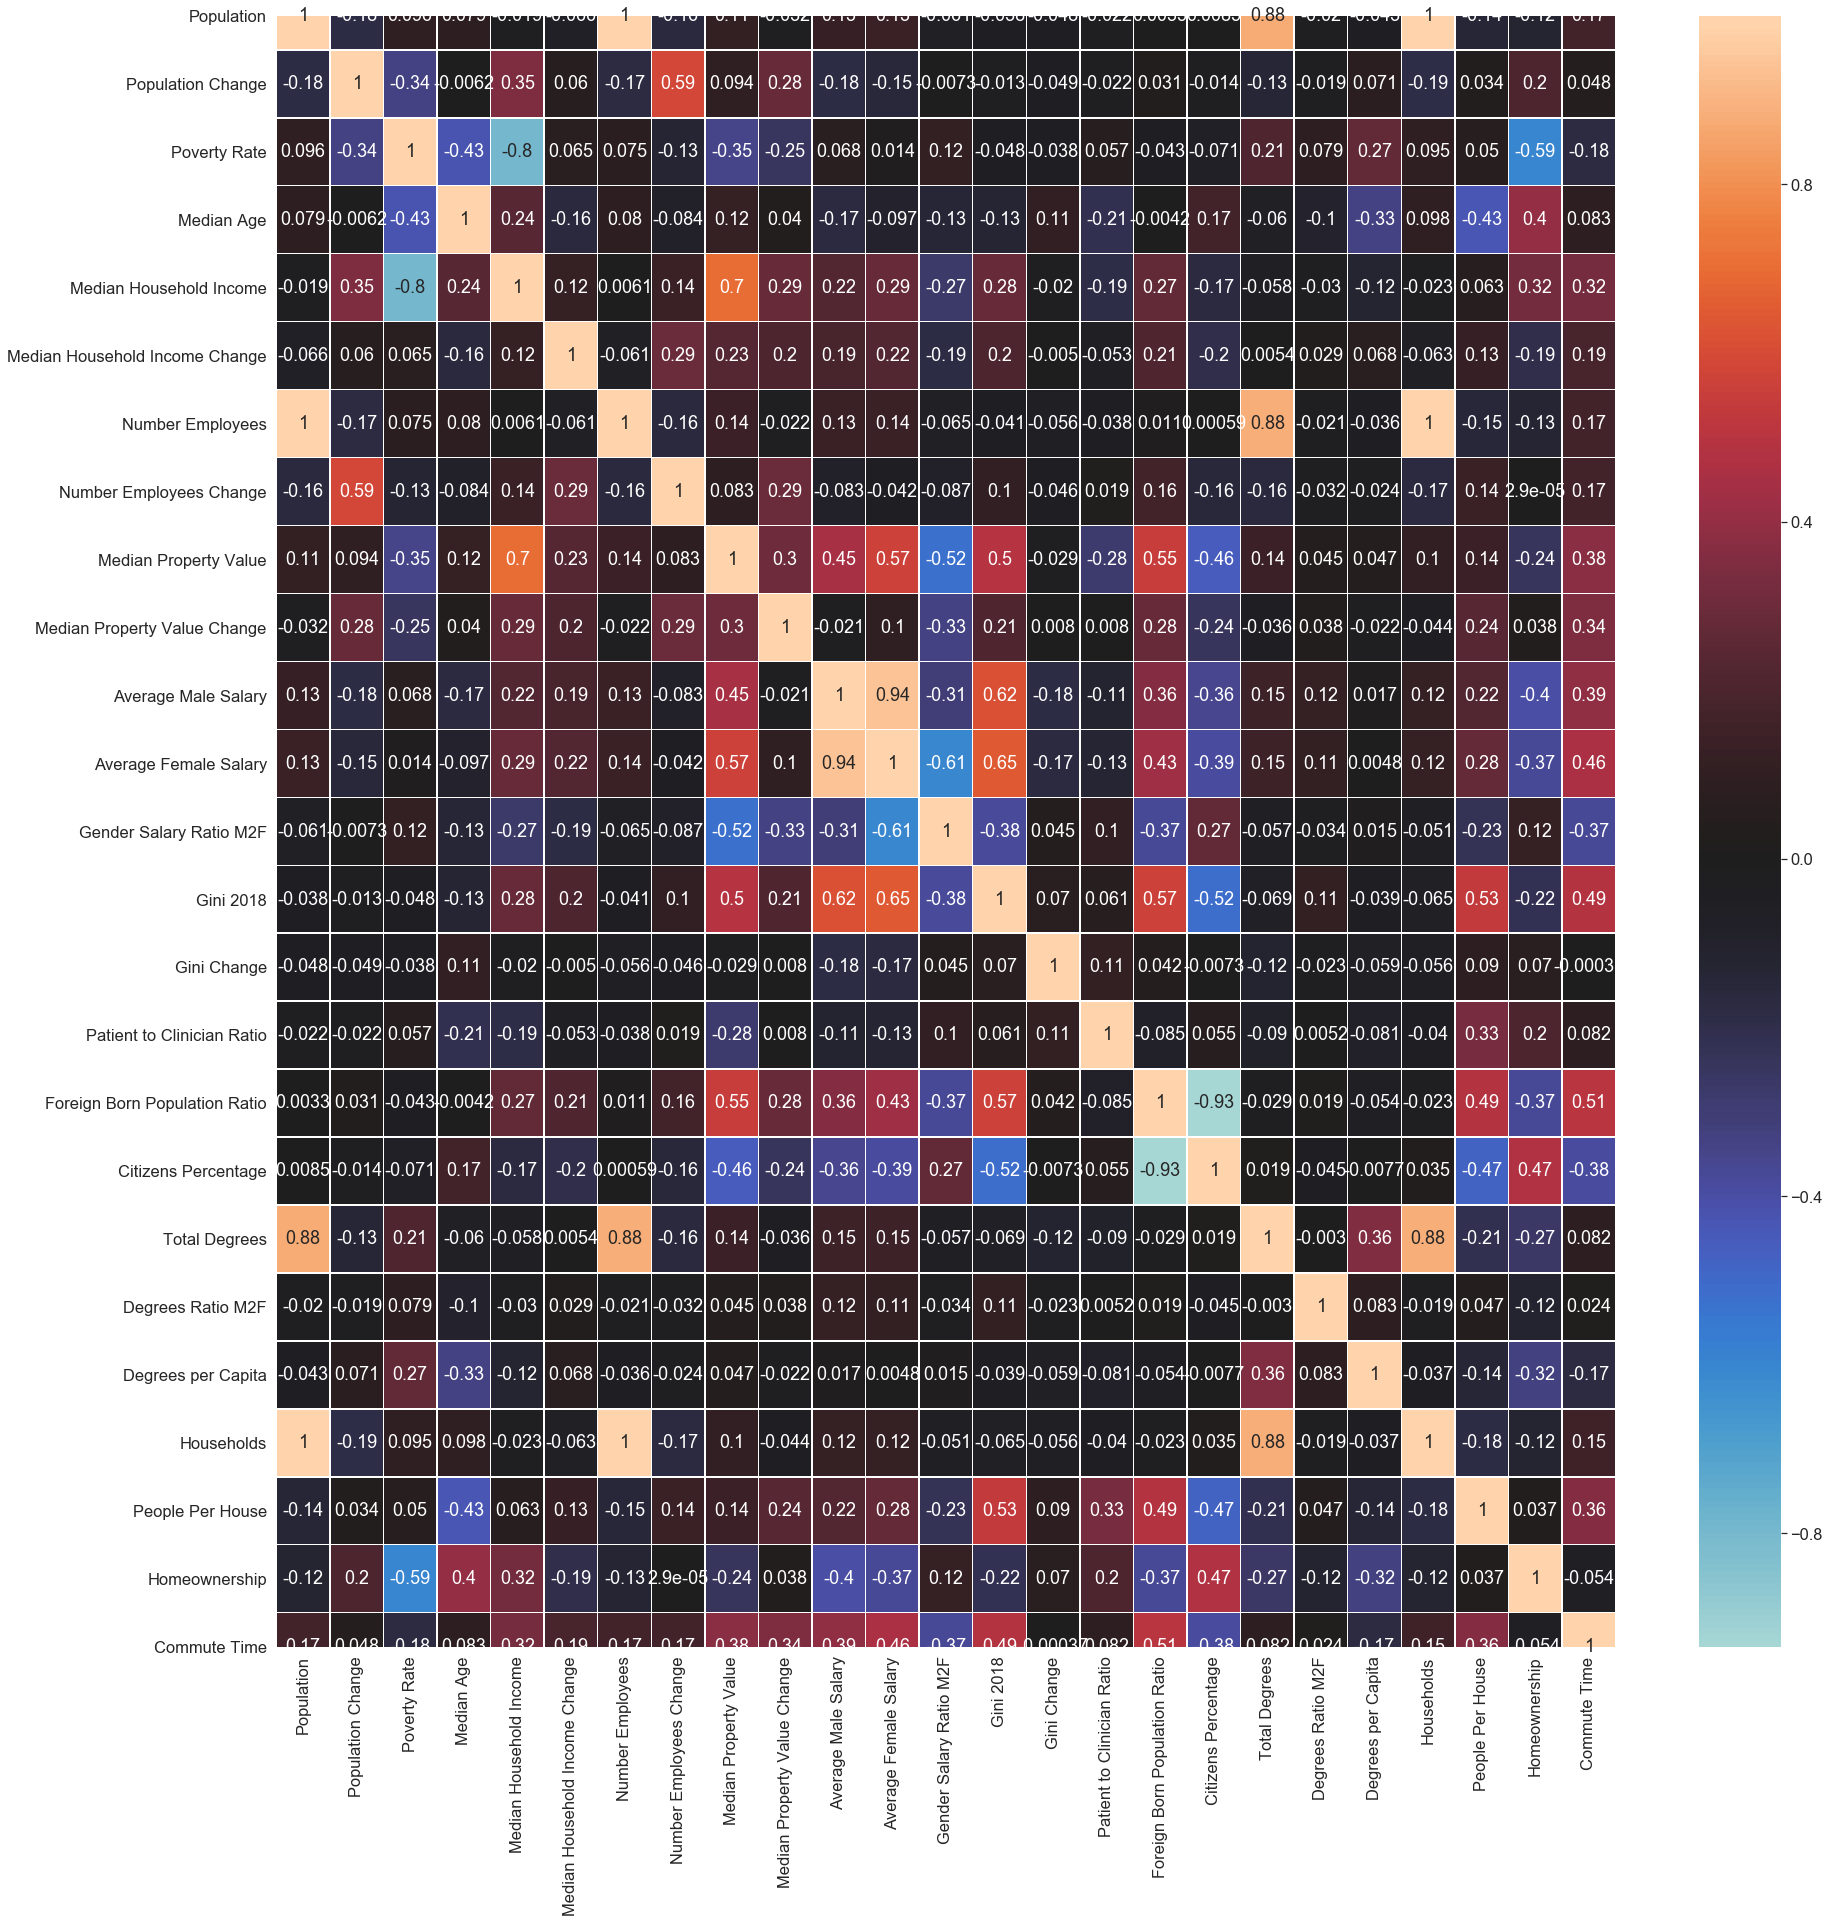

In [246]:
corrMatrix = onlyCon_df.corr()
plt.figure(figsize=(30,30))
sns.set(font_scale=1.5)
sns.heatmap(corrMatrix, annot=True, center=0, linewidths=0.5)
plt.show()

##### Extract geolocation data for each city and create some visualizations

In [247]:
m = folium.Map(location=[37.0902,-95.7129], no_touch=True ,zoom_start=4, min_zoom=4, max_zoom=7)

for i in range(0,len(cities)):
    folium.CircleMarker(
    location=[cities.iloc[i]['Latitude'],cities.iloc[i]['Longitude']],
    popup = cities.iloc[i]['City'],
    radius= cities.iloc[i]['Median Property Value']/cities.iloc[i]['Median Household Income']*2,
    color='crimson',
    fill = True,
    fill_color='crimson'
    ).add_to(m)
    
# for i in range(0,len(cities)):
#     folium.CircleMarker(
#     location=[cities.iloc[i]['Latitude'],cities.iloc[i]['Longitude']],
#     popup = cities.iloc[i]['City'],
#     radius= cities.iloc[i]['Median Property Value']/100000,
#     color='blue',
#     fill = True,
#     fill_color='crimson'
#     ).add_to(m)

m